# Notebook containing the code to fetch different portofolios from WRDS to be used for ANTICOR

## Top 25 stocks of the SnP 500

🚀 Étape 1: Connexion à WRDS et définition des paramètres...
Loading library list...
Done
Utilisateur raphael67850 connecté.
✅ Connexion et paramètres définis.

🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations...
Utilisation de la date de fin : 2024-12-31
✅ Univers de 25 actions identifié.

🚀 Étape 3: Téléchargement des données (avec COMNAM et TICKER)...
✅ Téléchargement terminé.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['ORCL', 'MSFT', 'XOM', 'META', 'GOOG', 'AAPL', 'PG', 'JNJ', 'JPM', 'LLY', 'WMT', 'BAC', 'HD', 'BRK', 'AMZN', 'NVDA', 'COST', 'NFLX', 'CRM', 'GOOGL', 'MA', 'V', 'UNH', 'AVGO', 'TSLA']
Shape de la matrice : (1000, 25)
------------------------------------------

🚀 Étape 5: Analyse de la diversification...

📊 Analyse 1: Génération de la Heatmap de corrélation...
-> Affichage de la Heatmap.


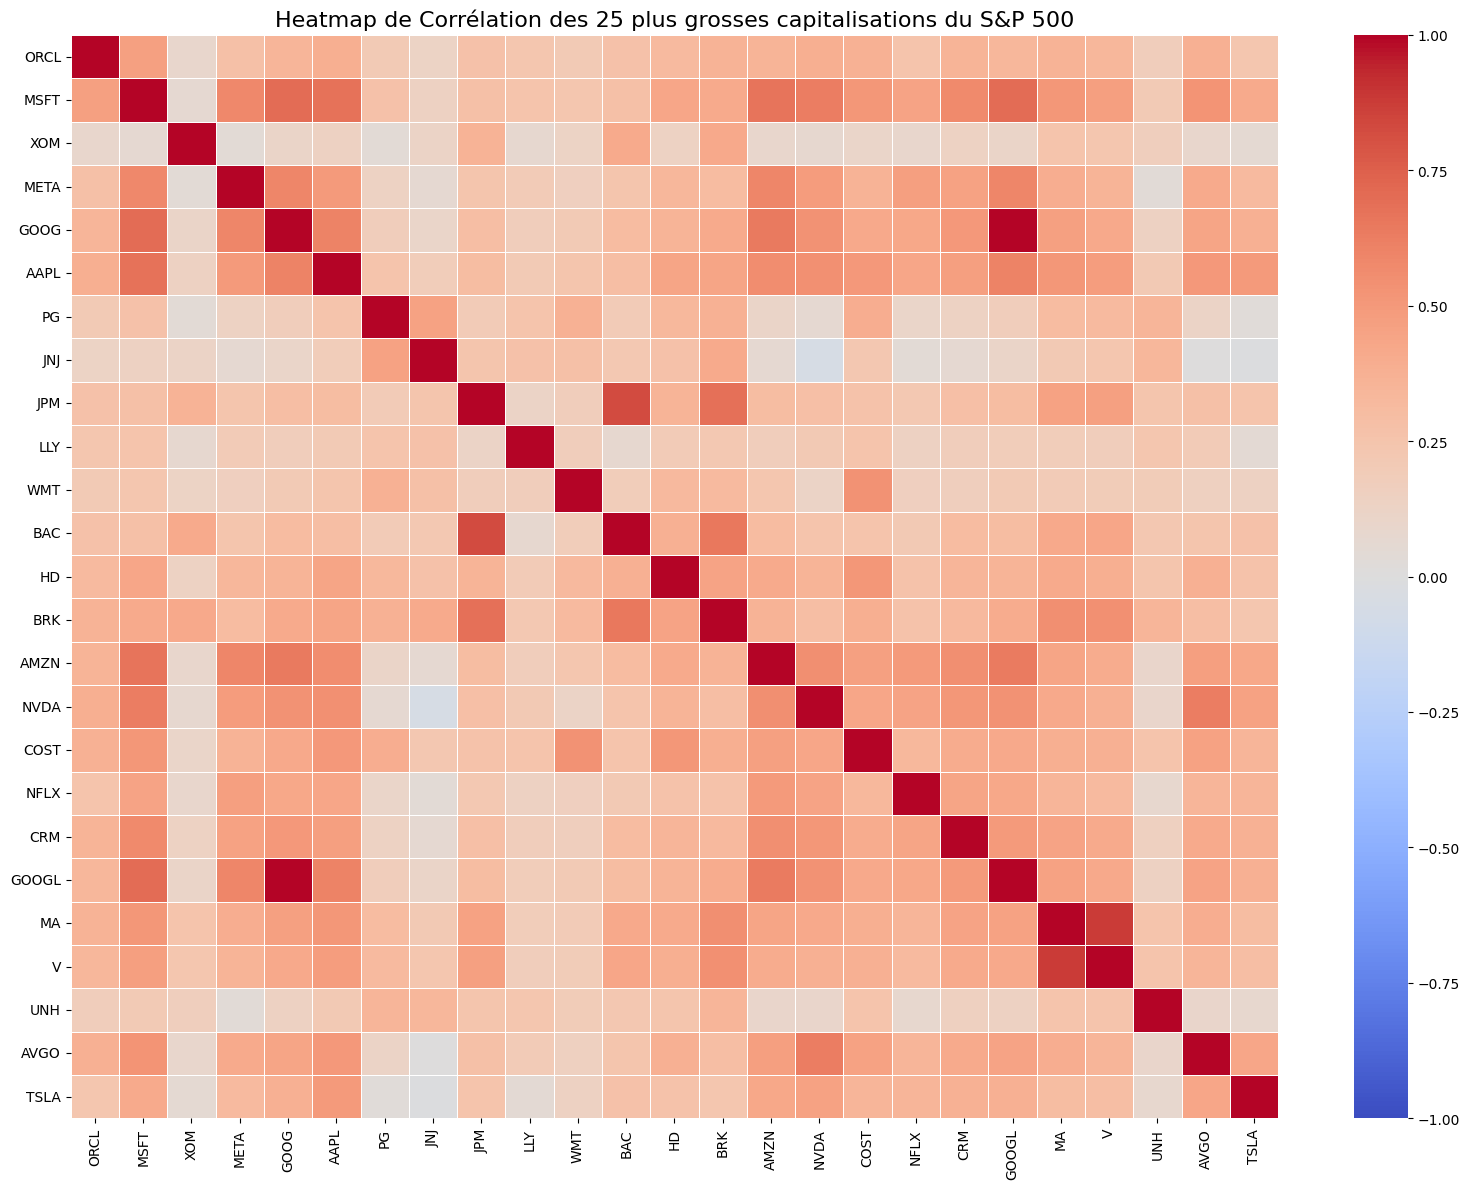


📊 Analyse 2: Calcul de la corrélation moyenne...
✅ Corrélation moyenne (hors-diagonale) du portefeuille : 0.3199
-> Interprétation : La corrélation moyenne est modérée. La diversification est présente mais limitée.

📊 Analyse 4: Analyse en Composantes Principales (ACP)...
✅ La première composante principale (PC1) explique à elle seule 36.91% de la variance totale.
-> Interprétation : PC1 représente 'le marché'. Si ce chiffre est élevé (ex: > 50%),
   cela signifie qu'un seul facteur (le mouvement général du marché) dicte la majorité
   des mouvements de votre portefeuille. C'est un signe de FAIBLE diversification.
✅ Il faut 11 composantes pour expliquer 80% de la variance.
-> Interprétation : Si ce chiffre est faible (ex: 1, 2 ou 3), le portefeuille est peu diversifié.
   S'il est élevé (ex: 10 ou plus), le portefeuille est bien diversifié.
-> Affichage du Scree Plot de l'ACP.


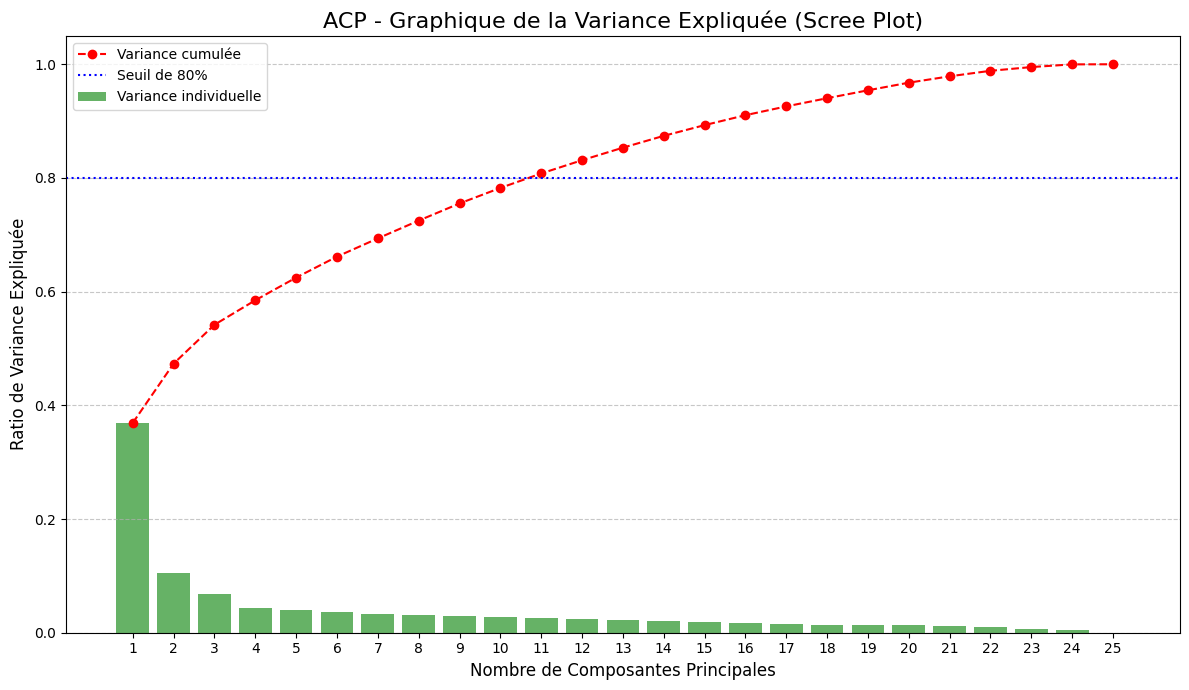


🎉 Analyse de diversification terminée.


In [2]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Ajouté pour la heatmap
from sklearn.decomposition import PCA  # Ajouté pour l'Analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # Ajouté pour la PCA

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
# Assurez-vous que votre fichier "wrds_credentials.txt" est au bon endroit
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"Utilisateur {user} connecté.")
except Exception as e:
    print(f"Erreur de connexion WRDS. Vérifiez 'wrds_credentials.txt'. Erreur: {e}")
    # Quitter le script si la connexion échoue
    exit()

end_date = '2025-01-30'
trading_days = 1000 # J'ai réduit à 1000 pour correspondre à votre demande initiale (1276 est aussi très bien)
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')
num_stocks = 25
print("✅ Connexion et paramètres définis.")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (TOP 25 S&P 500)
# =============================================================================
print("\n🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations...")
try:
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"Aucune donnée trouvée avant ou à la date {end_date}. Utilisation de la date du jour.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Utilisation de la date de fin : {end_date}")

    query_universe = f"""
        WITH sp500_constituents AS (
            SELECT permno FROM crsp.msp500list WHERE '{end_date}' BETWEEN start AND ending
        ),
        market_cap AS (
            SELECT a.permno, ABS(a.prc * a.shrout) as mktcap
            FROM crsp.dsf AS a JOIN sp500_constituents AS b ON a.permno = b.permno
            WHERE a.date = '{end_date}' AND a.prc IS NOT NULL AND a.shrout IS NOT NULL
        )
        SELECT permno FROM market_cap ORDER BY mktcap DESC LIMIT {num_stocks}
    """
    top_25_permno = db.raw_sql(query_universe)['permno'].tolist()
    permno_tuple = tuple(top_25_permno)
    print(f"✅ Univers de {len(top_25_permno)} actions identifié.")

except Exception as e:
    print(f"Erreur lors de la sélection de l'univers : {e}")
    db.close()
    exit()

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données (avec COMNAM et TICKER)...")
query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret, c.comnam, c.ticker
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    LEFT JOIN crsp.msenames AS c ON a.permno = c.permno AND a.date BETWEEN c.namedt AND c.nameendt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

# Amélioration de la récupération des Tickers/COMNAM
permno_to_info = {}
for permno in top_25_permno:
    df_perm = daily_data[daily_data['permno'] == permno].sort_values('date')
    last_comnam = df_perm['comnam'].ffill().bfill().iloc[-1] if not df_perm['comnam'].isnull().all() else 'N/A'
    last_ticker = df_perm['ticker'].ffill().bfill().iloc[-1] if not df_perm['ticker'].isnull().all() else str(permno)
    permno_to_info[permno] = {'comnam': last_comnam, 'ticker': last_ticker}

permno_to_ticker = {p: info['ticker'] for p, info in permno_to_info.items()}
permno_to_name = {p: info['comnam'] for p, info in permno_to_info.items()}

all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print("✅ Téléchargement terminé.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# Gestion plus robuste des NaNs
final_matrix_relatives.ffill(inplace=True) # D'abord forward fill
final_matrix_relatives.fillna(1.0, inplace=True) # Remplir les NaNs restants (début de série)

print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")


# =============================================================================
# ÉTAPE 5: ANALYSE DE LA DIVERSIFICATION
# =============================================================================
print("🚀 Étape 5: Analyse de la diversification...")

# 1. Préparer la matrice des rendements (et non des relatifs)
# C'est sur les rendements que l'on calcule la corrélation
returns_matrix = final_matrix_relatives - 1

# 2. Renommer les colonnes avec les Tickers pour des graphiques lisibles
returns_matrix.columns = [permno_to_ticker.get(col, str(col)) for col in returns_matrix.columns]

# --- Méthode 1: Heatmap de Corrélation ---
print("\n📊 Analyse 1: Génération de la Heatmap de corrélation...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=False,  # 'annot=True' serait illisible avec 25x25
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title(f'Heatmap de Corrélation des {num_stocks} plus grosses capitalisations du S&P 500', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
print("-> Affichage de la Heatmap.")
plt.show()

# --- Méthode 2: Corrélation Moyenne ---
print("\n📊 Analyse 2: Calcul de la corrélation moyenne...")

# On prend la partie triangulaire supérieure de la matrice (sans la diagonale)
# pour ne pas compter les paires deux fois, ni la corrélation d'un actif avec lui-même (qui est 1)
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Corrélation moyenne (hors-diagonale) du portefeuille : {mean_corr:.4f}")
if mean_corr > 0.5:
    print("-> Interprétation : La corrélation moyenne est très élevée. Le portefeuille est PEU diversifié.")
elif mean_corr > 0.2:
    print("-> Interprétation : La corrélation moyenne est modérée. La diversification est présente mais limitée.")
else:
    print("-> Interprétation : La corrélation moyenne est faible. Le portefeuille est BIEN diversifié.")

# --- Méthode 4: Analyse en Composantes Principales (ACP) ---
print("\n📊 Analyse 4: Analyse en Composantes Principales (ACP)...")

# 1. Standardiser les données (très important pour l'ACP)
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Appliquer l'ACP
# Nous calculons les 25 composantes pour voir la distribution complète
pca = PCA(n_components=num_stocks)
pca.fit(scaled_returns)

# 3. Analyser les résultats
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ La première composante principale (PC1) explique à elle seule {pc1_variance:.2%} de la variance totale.")
print("-> Interprétation : PC1 représente 'le marché'. Si ce chiffre est élevé (ex: > 50%),")
print("   cela signifie qu'un seul facteur (le mouvement général du marché) dicte la majorité")
print("   des mouvements de votre portefeuille. C'est un signe de FAIBLE diversification.")

# Trouver combien de composantes pour expliquer 80% de la variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ Il faut {components_for_80_variance} composantes pour expliquer 80% de la variance.")
    print("-> Interprétation : Si ce chiffre est faible (ex: 1, 2 ou 3), le portefeuille est peu diversifié.")
    print("   S'il est élevé (ex: 10 ou plus), le portefeuille est bien diversifié.")
except IndexError:
    print("-> Aucune composante n'explique 80% de la variance, ce qui est très improbable.")


# 4. Afficher le "Scree Plot" (Graphique des éboulis)
plt.figure(figsize=(12, 7))
components = range(1, num_stocks + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Variance individuelle')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Variance cumulée')

plt.title('ACP - Graphique de la Variance Expliquée (Scree Plot)', fontsize=16)
plt.xlabel('Nombre de Composantes Principales', fontsize=12)
plt.ylabel('Ratio de Variance Expliquée', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='Seuil de 80%')
plt.legend(loc='best')
plt.ylim(0, 1.05)
plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Affichage du Scree Plot de l'ACP.")
plt.show()

print("\n🎉 Analyse de diversification terminée.")

## Sélection de 25 Actions S&P 500 Diversifiées

**Secteur : Technologie (Information Technology)**
* Microsoft (MSFT)
* Apple (AAPL)
* Cisco Systems (CSCO)

**Secteur : Santé (Health Care)**
* Johnson & Johnson (JNJ)
* Pfizer (PFE)
* UnitedHealth Group (UNH)

**Secteur : Finances (Financials)**
* JPMorgan Chase (JPM)
* Bank of America (BAC)
* Wells Fargo (WFC)

**Secteur : Services de Communication (Communication Services)**
* Alphabet (GOOGL)
* Meta Platforms (META)

**Secteur : Biens de Consommation Discrétionnaire (Consumer Discretionary)**
* Amazon (AMZN)
* Home Depot (HD)

**Secteur : Biens de Consommation de Base (Consumer Staples)**
* Procter & Gamble (PG)
* Costco Wholesale (COST)
* Coca-Cola (KO)

**Secteur : Industrie (Industrials)**
* Caterpillar (CAT)
* Honeywell (HON)

**Secteur : Énergie (Energy)**
* Exxon Mobil (XOM)
* Chevron (CVX)

**Secteur : Services Publics (Utilities)**
* NextEra Energy (NEE)
* Southern Company (SO)

**Secteur : Immobilier (Real Estate)**
* American Tower (AMT)

**Secteur : Matériaux (Materials)**
* Air Products and Chemicals (APB)
* Sherwin-Williams (SHW)

🚀 Étape 1: Connexion à WRDS et définition des paramètres...
Loading library list...
Done
Utilisateur raphael67850 connecté.
✅ Paramètres définis. Objectif : 25 actions diversifiées.

🚀 Étape 2: Sélection de l'univers des 25 actions diversifiées...
Utilisation de la date de fin : 2024-12-31
✅ Univers de 25 actions identifié.
Actions trouvées: ['AAPL', 'AMT', 'AMZN', 'APD', 'BAC', 'CAT', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 'HON', 'JNJ', 'JPM', 'KO', 'META', 'MSFT', 'NEE', 'PFE', 'PG', 'SHW', 'SO', 'UNH', 'WFC', 'XOM']

🚀 Étape 3: Téléchargement des données historiques...
✅ Téléchargement terminé.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['MSFT', 'HON', 'KO', 'XOM', 'META', 'CVX', 'AAPL', 'PG', 'SO', 'CAT', 'PFE', 'JNJ', 'NEE', 'APD', 'SHW', 'WFC', 'JPM', 'BAC', 'HD', 'CSCO', 'AMZN', 'AMT', 'COST', 'GOOGL', 'UNH']
Shape de la matrice : (1000, 25)
--------

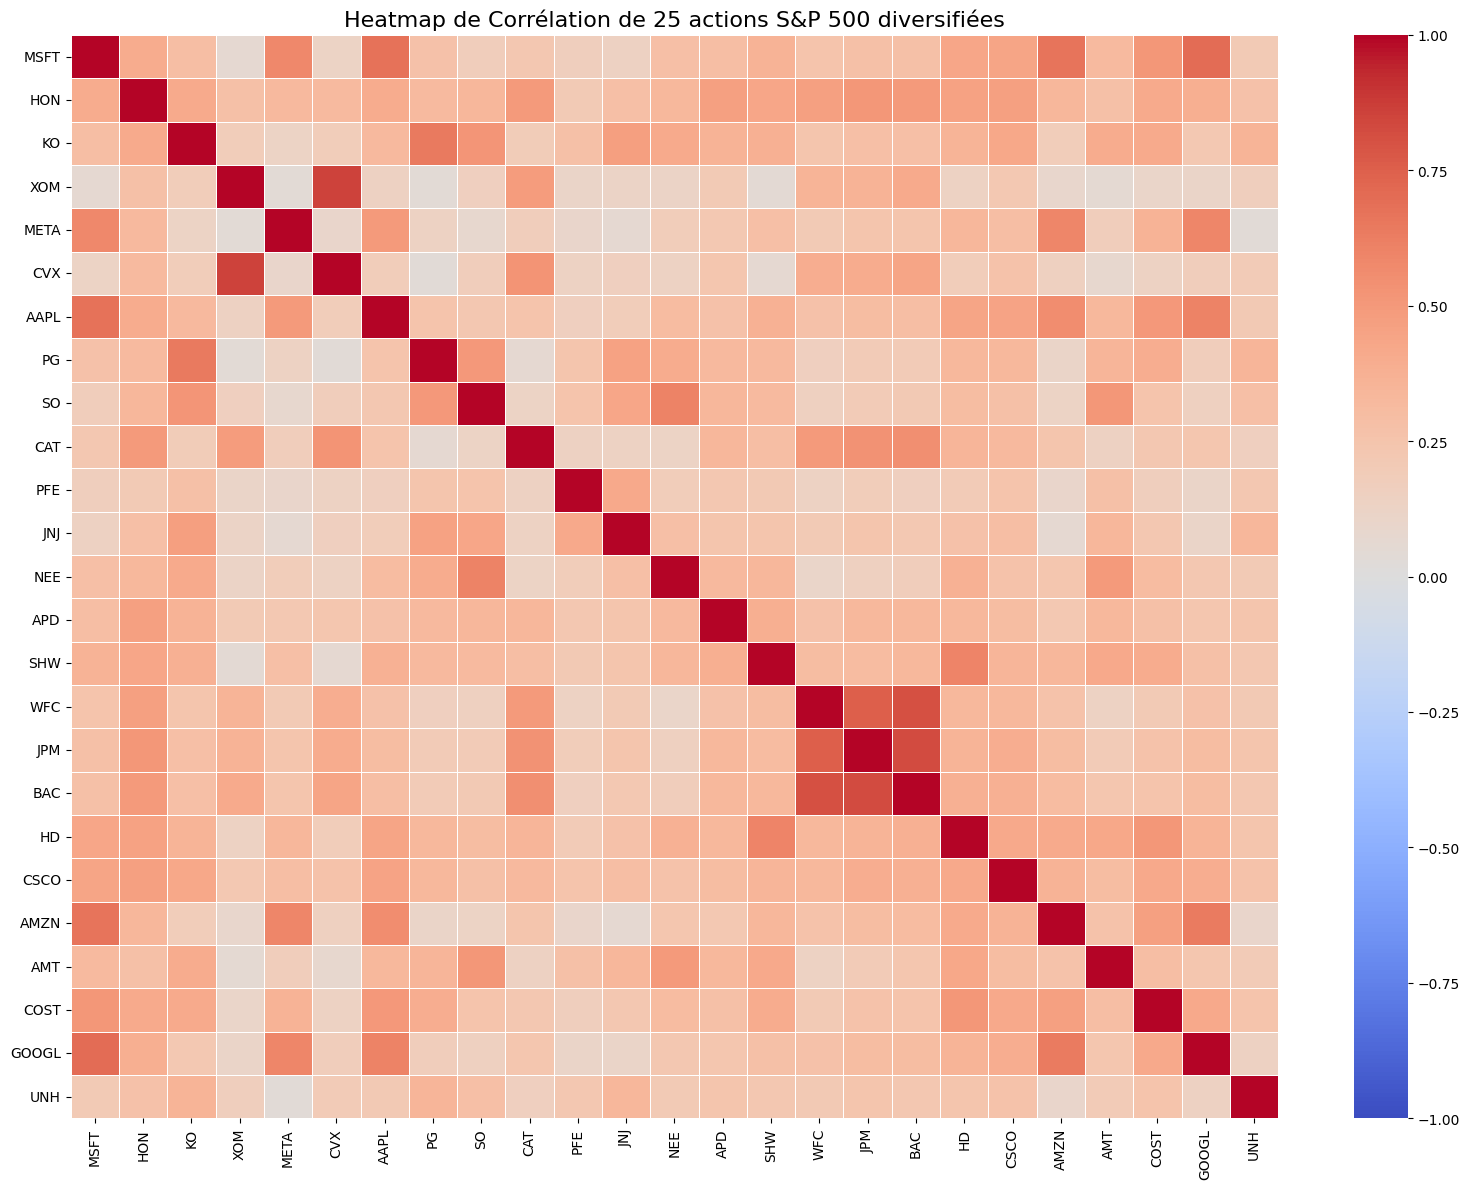


📊 Analyse 2: Calcul de la corrélation moyenne...
✅ Corrélation moyenne (hors-diagonale) du portefeuille : 0.2958
-> Interprétation : La corrélation moyenne est modérée. La diversification est présente mais limitée.

📊 Analyse 4: Analyse en Composantes Principales (ACP)...
✅ La première composante principale (PC1) explique à elle seule 33.15% de la variance totale.
-> Interprétation : PC1 représente 'le marché'. Si ce chiffre est élevé (ex: > 50%),
   cela signifie qu'un seul facteur (le mouvement général du marché) dicte la majorité
   des mouvements de votre portefeuille. C'est un signe de FAIBLE diversification.
✅ Il faut 11 composantes pour expliquer 80% de la variance.
-> Interprétation : Si ce chiffre est faible (ex: 1, 2 ou 3), le portefeuille est peu diversifié.
   S'il est élevé (ex: 10 ou plus), le portefeuille est bien diversifié.
-> Affichage du Scree Plot de l'ACP.


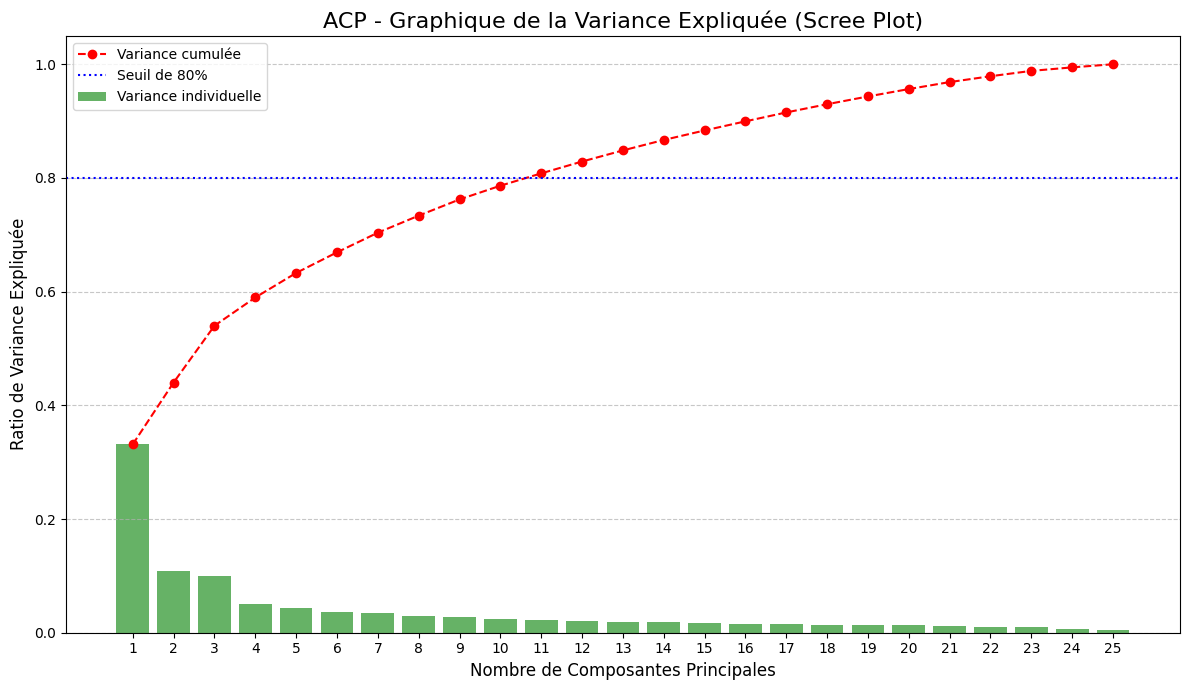


🎉 Analyse de diversification terminée.


In [4]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Ajouté pour la heatmap
from sklearn.decomposition import PCA  # Ajouté pour l'Analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # Ajouté pour la PCA

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
# Assurez-vous que votre fichier "wrds_credentials.txt" est au bon endroit
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"Utilisateur {user} connecté.")
except Exception as e:
    print(f"Erreur de connexion WRDS. Vérifiez 'wrds_credentials.txt'. Erreur: {e}")
    # Quitter le script si la connexion échoue
    exit()

end_date = '2025-01-30'
trading_days = 1000 # 1000 derniers jours
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')

# Liste des 25 tickers diversifiés (choisis par l'IA)
# ***** MODIFICATION ICI *****
# 'LIN' a été remplacé par 'APD' (Air Products and Chemicals)
target_tickers = [
    'MSFT', 'AAPL', 'CSCO',  # Tech
    'JNJ', 'PFE', 'UNH',     # Santé
    'JPM', 'BAC', 'WFC',     # Finance
    'GOOGL', 'META',         # Comm. Services
    'AMZN', 'HD',            # Cons. Discretionary
    'PG', 'COST', 'KO',      # Cons. Staples
    'CAT', 'HON',            # Industrials
    'XOM', 'CVX',            # Energy
    'NEE', 'SO',             # Utilities
    'AMT',                   # Real Estate
    'APD', 'SHW'             # Materials (remplacement de 'LIN' par 'APD')
]
target_tickers_tuple = tuple(target_tickers)
# num_stocks sera défini dans l'étape 2 en fonction de ce qui est réellement trouvé
print(f"✅ Paramètres définis. Objectif : {len(target_tickers)} actions diversifiées.")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (25 ACTIONS DIVERSIFIÉES)
# =============================================================================
print(f"\n🚀 Étape 2: Sélection de l'univers des {len(target_tickers)} actions diversifiées...")
try:
    # 1. Obtenir la dernière date de trading valide
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"Aucune donnée trouvée avant ou à la date {end_date}. Utilisation de la date du jour.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Utilisation de la date de fin : {end_date}")

    # 2. Requête pour trouver les PERMNO des tickers, en vérifiant l'appartenance au S&P 500
    query_universe = f"""
        WITH ticker_permnos AS (
            SELECT permno, ticker
            FROM crsp.msenames
            WHERE ticker IN {target_tickers_tuple}
            AND '{end_date}' BETWEEN namedt AND nameendt
        ),
        sp500_check AS (
            SELECT permno
            FROM crsp.msp500list
            WHERE start <= '2017-01-01' -- Contrainte d'ancienneté
            AND ending >= '{end_date}'   -- Toujours dans l'indice
            GROUP BY permno
        )
        SELECT a.permno, a.ticker
        FROM ticker_permnos AS a
        JOIN sp500_check AS b ON a.permno = b.permno
    """
    universe_df = db.raw_sql(query_universe)
    
    found_tickers = universe_df['ticker'].tolist()
    missing_tickers = list(set(target_tickers) - set(found_tickers))
    
    if missing_tickers:
        print(f"⚠️ Attention: Tickers suivants non trouvés ou ne respectant pas les critères S&P 2017: {missing_tickers}")

    target_permno = universe_df['permno'].tolist()
    permno_tuple = tuple(target_permno)
    
    # ***** MODIFICATION ICI *****
    # Rendre le code robuste : num_stocks est le nombre d'actions *réellement* trouvées
    num_stocks = len(target_permno) 
    
    # Créer le mapping PERMNO -> Ticker pour une utilisation future
    permno_to_ticker_map = universe_df.set_index('permno')['ticker'].to_dict()
    
    print(f"✅ Univers de {num_stocks} actions identifié.")
    print(f"Actions trouvées: {found_tickers}")

except Exception as e:
    print(f"Erreur lors de la sélection de l'univers : {e}")
    db.close()
    exit()
    
if not permno_tuple:
    print("Aucune action ne correspond aux critères. Arrêt du script.")
    db.close()
    exit()

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données historiques...")
# Query simplifiée car nous avons déjà les tickers
query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print("✅ Téléchargement terminé.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# Gestion plus robuste des NaNs
final_matrix_relatives.ffill(inplace=True) # D'abord forward fill
final_matrix_relatives.fillna(1.0, inplace=True) # Remplir les NaNs restants (début de série)

print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker_map.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")

# =============================================================================
# ÉTAPE 5: ANALYSE DE LA DIVERSIFICATION
# =============================================================================
print("🚀 Étape 5: Analyse de la diversification...")

# 1. Préparer la matrice des rendements (et non des relatifs)
returns_matrix = final_matrix_relatives - 1

# 2. Renommer les colonnes avec les Tickers pour des graphiques lisibles
returns_matrix.columns = [permno_to_ticker_map.get(col, str(col)) for col in returns_matrix.columns]

# --- Méthode 1: Heatmap de Corrélation ---
print("\n📊 Analyse 1: Génération de la Heatmap de corrélation...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=False,  # 'annot=True' serait illisible avec 25x25
    cmap='coolwarm', # Utilisation de 'coolwarm' (bleu-rouge) pour bien voir les extrêmes
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title(f'Heatmap de Corrélation de {num_stocks} actions S&P 500 diversifiées', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
print("-> Affichage de la Heatmap.")
plt.show()

# --- Méthode 2: Corrélation Moyenne ---
print("\n📊 Analyse 2: Calcul de la corrélation moyenne...")
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Corrélation moyenne (hors-diagonale) du portefeuille : {mean_corr:.4f}")
if mean_corr > 0.5:
    print("-> Interprétation : La corrélation moyenne est élevée. Le portefeuille est PEU diversifié.")
elif mean_corr > 0.2:
    print("-> Interprétation : La corrélation moyenne est modérée. La diversification est présente mais limitée.")
else:
    print("-> Interprétation : La corrélation moyenne est faible. Le portefeuille est BIEN diversifié.")

# --- Méthode 4: Analyse en Composantes Principales (ACP) ---
print("\n📊 Analyse 4: Analyse en Composantes Principales (ACP)...")

# 1. Standardiser les données (très important pour l'ACP)
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Appliquer l'ACP
# 'num_stocks' est maintenant égal au nombre de colonnes de 'scaled_returns'
pca = PCA(n_components=num_stocks) 
pca.fit(scaled_returns)

# 3. Analyser les résultats
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ La première composante principale (PC1) explique à elle seule {pc1_variance:.2%} de la variance totale.")
print("-> Interprétation : PC1 représente 'le marché'. Si ce chiffre est élevé (ex: > 50%),")
print("   cela signifie qu'un seul facteur (le mouvement général du marché) dicte la majorité")
print("   des mouvements de votre portefeuille. C'est un signe de FAIBLE diversification.")

# Trouver combien de composantes pour expliquer 80% de la variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ Il faut {components_for_80_variance} composantes pour expliquer 80% de la variance.")
    print("-> Interprétation : Si ce chiffre est faible (ex: 1, 2 ou 3), le portefeuille est peu diversifié.")
    print("   S'il est élevé (ex: 10 ou plus), le portefeuille est bien diversifié.")
except IndexError:
    print("-> Aucune composante n'explique 80% de la variance, ce qui est très improbable.")


# 4. Afficher le "Scree Plot" (Graphique des éboulis)
plt.figure(figsize=(12, 7))
# S'assurer que 'components' a la bonne longueur
components = range(1, len(explained_variance_ratio) + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Variance individuelle')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Variance cumulée')

plt.title('ACP - Graphique de la Variance Expliquée (Scree Plot)', fontsize=16)
plt.xlabel('Nombre de Composantes Principales', fontsize=12)
plt.ylabel('Ratio de Variance Expliquée', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='Seuil de 80%')
plt.legend(loc='best')
plt.ylim(0, 1.05)
# S'assurer que les ticks correspondent au nombre de composants
if num_stocks <= 30: # N'afficher les ticks que si c'est lisible
    plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Affichage du Scree Plot de l'ACP.")
plt.show()

print("\n🎉 Analyse de diversification terminée.")

## Nyse (Top 25)

🚀 Étape 1: Connexion à WRDS et définition des paramètres...
Loading library list...
Done
Utilisateur raphael67850 connecté.
✅ Paramètres définis. Objectif : Top 25 actions du NYSE.

🚀 Étape 2: Sélection de l'univers des 25 plus grosses capitalisations du NYSE...
Utilisation de la date de fin : 2024-12-31
✅ Univers de 25 actions identifié.
Actions trouvées: ['LLY', 'WMT', 'JPM', 'BRK', 'V', 'MA', 'XOM', 'ORCL', 'UNH', 'PG', 'HD', 'BRK', 'JNJ', 'BAC', 'CRM', 'ABBV', 'KO', 'CVX', 'MRK', 'WFC', 'NOW', 'AXP', 'MCD', 'IBM', 'MS']

🚀 Étape 3: Téléchargement des données historiques...
✅ Téléchargement terminé.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['ORCL', 'KO', 'XOM', 'IBM', 'NOW', 'ABBV', 'CVX', 'BRK', 'PG', 'JNJ', 'MRK', 'WFC', 'MCD', 'JPM', 'LLY', 'WMT', 'AXP', 'BAC', 'HD', 'MS', 'BRK', 'CRM', 'MA', 'V', 'UNH']
Shape de la matrice : (1000, 25)
-----------

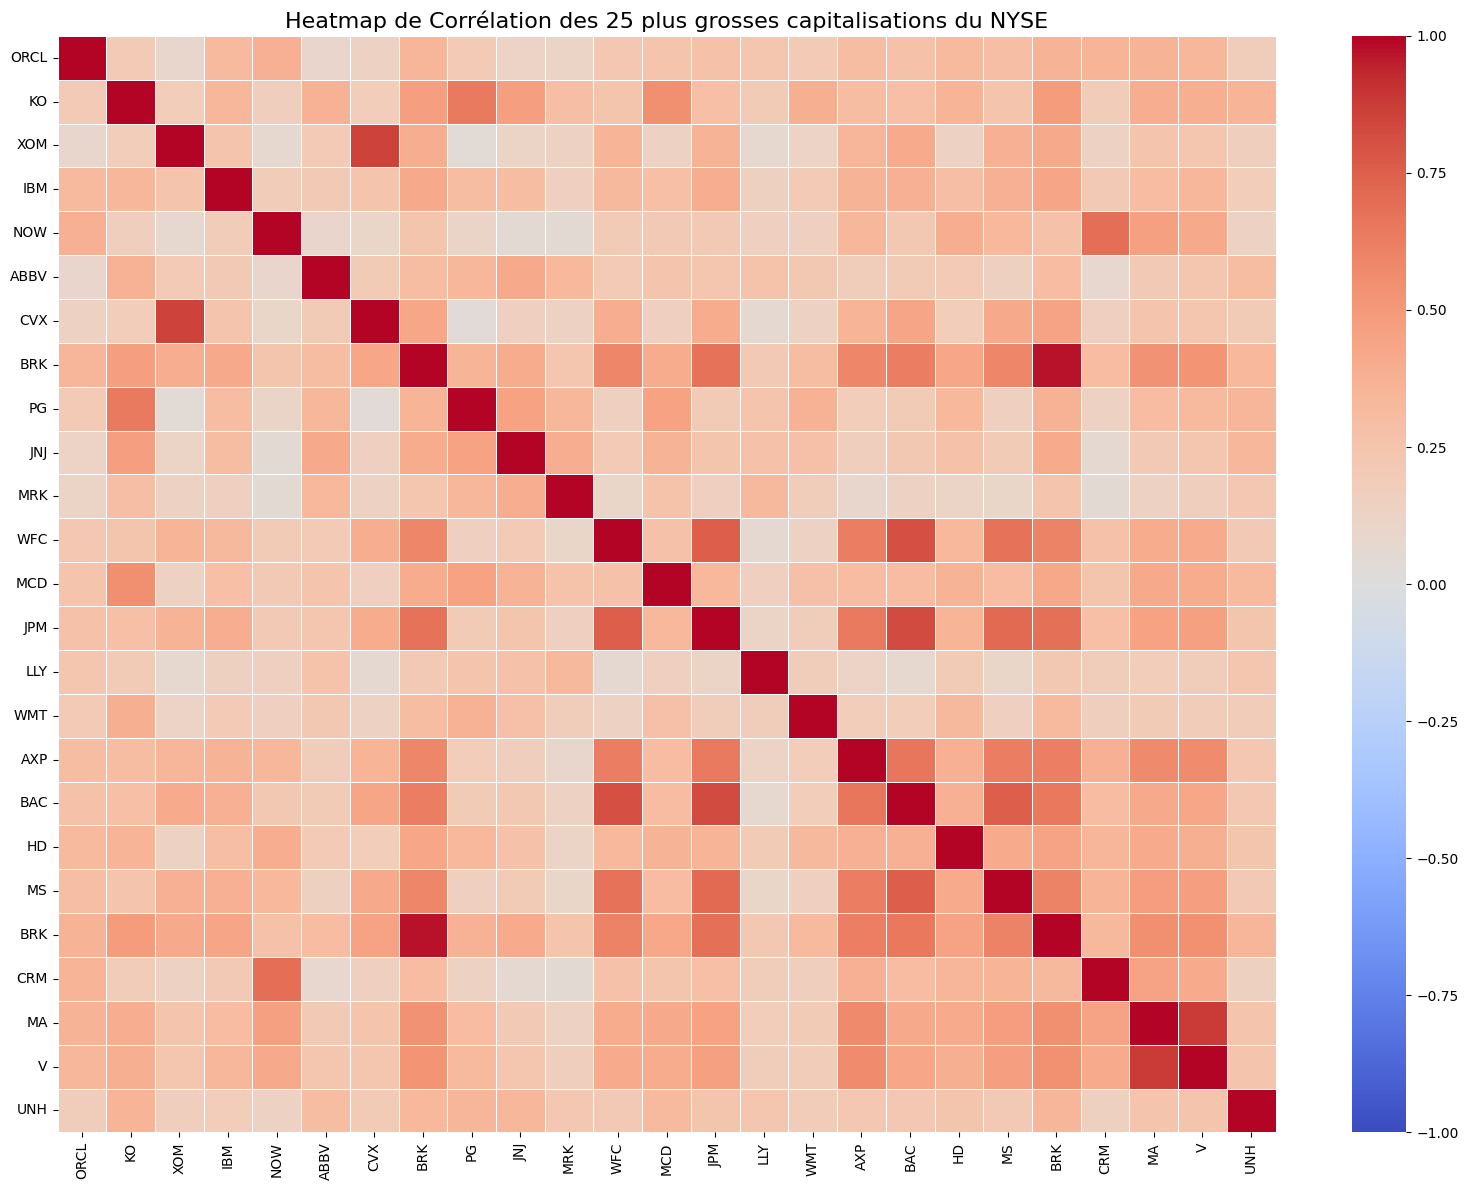


📊 Analyse 2: Calcul de la corrélation moyenne...
✅ Corrélation moyenne (hors-diagonale) du portefeuille : 0.3081
-> Interprétation : La corrélation moyenne est modérée. La diversification est présente mais limitée.

📊 Analyse 4: Analyse en Composantes Principales (ACP)...
✅ La première composante principale (PC1) explique à elle seule 35.59% de la variance totale.
-> Interprétation : PC1 représente 'le marché'. Si ce chiffre est élevé (ex: > 50%),
   cela signifie qu'un seul facteur (le mouvement général du marché) dicte la majorité
   des mouvements de votre portefeuille. C'est un signe de FAIBLE diversification.
✅ Il faut 11 composantes pour expliquer 80% de la variance.
-> Interprétation : Si ce chiffre est faible (ex: 1, 2 ou 3), le portefeuille est peu diversifié.
   S'il est élevé (ex: 10 ou plus), le portefeuille est bien diversifié.
-> Affichage du Scree Plot de l'ACP.


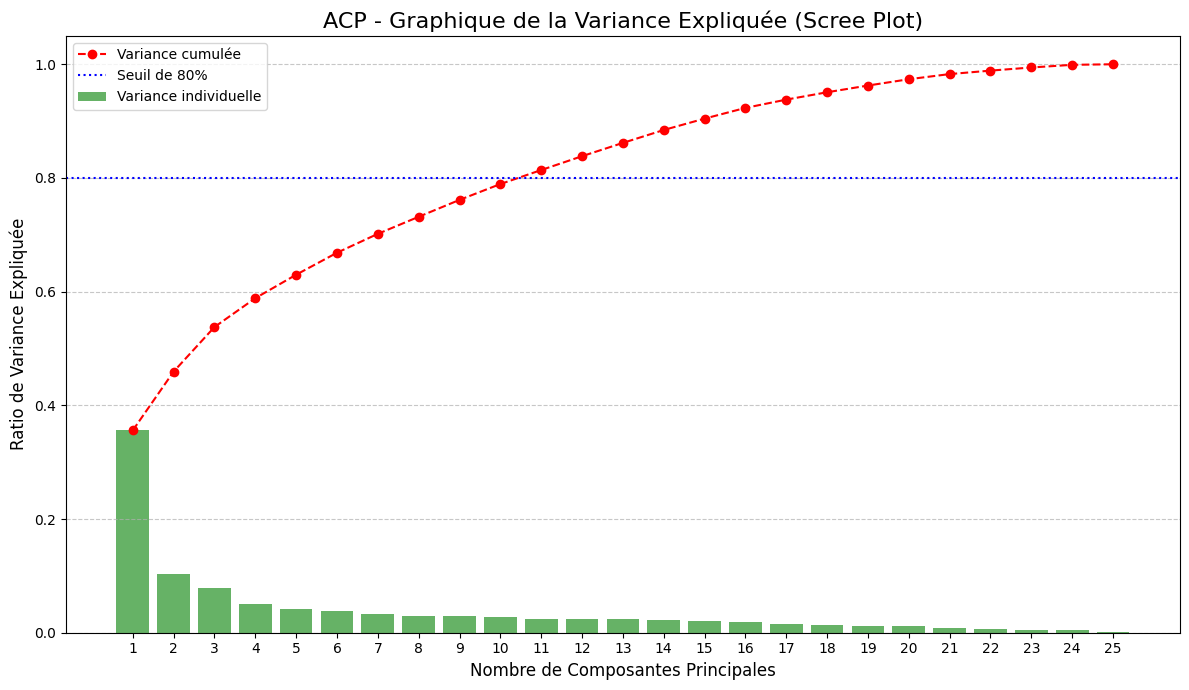


🎉 Analyse de diversification terminée.


In [5]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Ajouté pour la heatmap
from sklearn.decomposition import PCA  # Ajouté pour l'Analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # Ajouté pour la PCA

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
# Assurez-vous que votre fichier "wrds_credentials.txt" est au bon endroit
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"Utilisateur {user} connecté.")
except Exception as e:
    print(f"Erreur de connexion WRDS. Vérifiez 'wrds_credentials.txt'. Erreur: {e}")
    # Quitter le script si la connexion échoue
    exit()

end_date = '2025-01-30'
trading_days = 1000 # 1000 derniers jours
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')
num_stocks = 25 # Nous visons les 25 plus grosses
print(f"✅ Paramètres définis. Objectif : Top {num_stocks} actions du NYSE.")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (TOP 25 NYSE)
# =============================================================================
print(f"\n🚀 Étape 2: Sélection de l'univers des {num_stocks} plus grosses capitalisations du NYSE...")
try:
    # 1. Obtenir la dernière date de trading valide
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"Aucune donnée trouvée avant ou à la date {end_date}. Utilisation de la date du jour.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Utilisation de la date de fin : {end_date}")

    # 2. Requête pour trouver les PERMNO des 25 plus grosses capitalisations du NYSE
    # exchcd = 1 (NYSE)
    # shrcd = 10 ou 11 (Actions ordinaires)
    query_universe = f"""
        WITH nyse_stocks AS (
            SELECT permno, ticker, comnam
            FROM crsp.msenames
            WHERE exchcd = 1 -- Filtre pour le NYSE
            AND shrcd IN (10, 11) -- Actions ordinaires
            AND '{end_date}' BETWEEN namedt AND nameendt
        ),
        market_cap AS (
            SELECT a.permno, a.ticker, a.comnam, ABS(b.prc * b.shrout) as mktcap
            FROM nyse_stocks AS a
            JOIN crsp.dsf AS b ON a.permno = b.permno
            WHERE b.date = '{end_date}'
            AND b.prc IS NOT NULL AND b.shrout IS NOT NULL
        )
        SELECT permno, ticker, comnam
        FROM market_cap
        ORDER BY mktcap DESC
        LIMIT {num_stocks}
    """
    universe_df = db.raw_sql(query_universe)
    
    found_tickers = universe_df['ticker'].tolist()
    target_permno = universe_df['permno'].tolist()
    permno_tuple = tuple(target_permno)
    
    # Mettre à jour num_stocks au cas où moins de 25 seraient trouvées
    num_stocks = len(target_permno)
    
    # Créer le mapping PERMNO -> Ticker pour une utilisation future
    permno_to_ticker_map = universe_df.set_index('permno')['ticker'].to_dict()
    
    print(f"✅ Univers de {num_stocks} actions identifié.")
    print(f"Actions trouvées: {found_tickers}")

except Exception as e:
    print(f"Erreur lors de la sélection de l'univers : {e}")
    db.close()
    exit()
    
if not permno_tuple:
    print("Aucune action ne correspond aux critères. Arrêt du script.")
    db.close()
    exit()

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données historiques...")
query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print("✅ Téléchargement terminé.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# Gestion plus robuste des NaNs
final_matrix_relatives.ffill(inplace=True) # D'abord forward fill
final_matrix_relatives.fillna(1.0, inplace=True) # Remplir les NaNs restants (début de série)

print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker_map.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")

# =============================================================================
# ÉTAPE 5: ANALYSE DE LA DIVERSIFICATION
# =============================================================================
print("🚀 Étape 5: Analyse de la diversification...")

# 1. Préparer la matrice des rendements (et non des relatifs)
returns_matrix = final_matrix_relatives - 1

# 2. Renommer les colonnes avec les Tickers pour des graphiques lisibles
returns_matrix.columns = [permno_to_ticker_map.get(col, str(col)) for col in returns_matrix.columns]

# --- Méthode 1: Heatmap de Corrélation ---
print("\n📊 Analyse 1: Génération de la Heatmap de corrélation...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=False,  # 'annot=True' serait illisible avec 25x25
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title(f'Heatmap de Corrélation des {num_stocks} plus grosses capitalisations du NYSE', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
print("-> Affichage de la Heatmap.")
plt.show()

# --- Méthode 2: Corrélation Moyenne ---
print("\n📊 Analyse 2: Calcul de la corrélation moyenne...")
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Corrélation moyenne (hors-diagonale) du portefeuille : {mean_corr:.4f}")
if mean_corr > 0.5:
    print("-> Interprétation : La corrélation moyenne est élevée. Le portefeuille est PEU diversifié.")
elif mean_corr > 0.2:
    print("-> Interprétation : La corrélation moyenne est modérée. La diversification est présente mais limitée.")
else:
    print("-> Interprétation : La corrélation moyenne est faible. Le portefeuille est BIEN diversifié.")

# --- Méthode 4: Analyse en Composantes Principales (ACP) ---
print("\n📊 Analyse 4: Analyse en Composantes Principales (ACP)...")

# 1. Standardiser les données (très important pour l'ACP)
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Appliquer l'ACP
# 'num_stocks' est maintenant égal au nombre de colonnes de 'scaled_returns'
pca = PCA(n_components=num_stocks) 
pca.fit(scaled_returns)

# 3. Analyser les résultats
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ La première composante principale (PC1) explique à elle seule {pc1_variance:.2%} de la variance totale.")
print("-> Interprétation : PC1 représente 'le marché'. Si ce chiffre est élevé (ex: > 50%),")
print("   cela signifie qu'un seul facteur (le mouvement général du marché) dicte la majorité")
print("   des mouvements de votre portefeuille. C'est un signe de FAIBLE diversification.")

# Trouver combien de composantes pour expliquer 80% de la variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ Il faut {components_for_80_variance} composantes pour expliquer 80% de la variance.")
    print("-> Interprétation : Si ce chiffre est faible (ex: 1, 2 ou 3), le portefeuille est peu diversifié.")
    print("   S'il est élevé (ex: 10 ou plus), le portefeuille est bien diversifié.")
except IndexError:
    print("-> Aucune composante n'explique 80% de la variance, ce qui est très improbable.")


# 4. Afficher le "Scree Plot" (Graphique des éboulis)
plt.figure(figsize=(12, 7))
# S'assurer que 'components' a la bonne longueur
components = range(1, len(explained_variance_ratio) + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Variance individuelle')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Variance cumulée')

plt.title('ACP - Graphique de la Variance Expliquée (Scree Plot)', fontsize=16)
plt.xlabel('Nombre de Composantes Principales', fontsize=12)
plt.ylabel('Ratio de Variance Expliquée', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='Seuil de 80%')
plt.legend(loc='best')
plt.ylim(0, 1.05)
# S'assurer que les ticks correspondent au nombre de composants
if num_stocks <= 30: # N'afficher les ticks que si c'est lisible
    plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Affichage du Scree Plot de l'ACP.")
plt.show()

print("\n🎉 Analyse de diversification terminée.")

## Selected Universe: 25 Multi-Asset Securities

This portfolio is designed for broad diversification and includes US-listed stocks, commodities, international equities (via ETFs or ADRs), and cryptocurrency exposure.

**US Stocks (from user list):**
* **AMD** (Advanced Micro Devices)
* **AVGO** (Broadcom)
* **IONQ** (IonQ)
* **JPM** (JPMorgan Chase)
* **META** (Meta Platforms)
* **MRVL** (Marvell Technology)
* **NTLA** (Intellia Therapeutics)
* **ORCL** (Oracle)
* **QBTS** (D-Wave Quantum)
* **UNH** (UnitedHealth Group)

**ETFs & Commodities (from user list):**
* **GOLD** (Barrick Gold Corp) - *Note: This is a gold miner, not the spot price.*
* **URA** (Global X Uranium ETF)
* **USO** (United States Oil Fund) - *Substitution for 'OIL'*

**US-listed Substitutions (for International & Crypto):**
* **APD** (Air Products) - *Substitution for 'Air Liquide'*
* **CPRI** (Capri Holdings) - *Substitution for 'Kering'*
* **EL** (Estee Lauder) - *Substitution for 'LVMH'*
* **EWQ** (iShares MSCI France ETF) - *Substitution for 'CAC 40'*
* **GBTC** (Grayscale Bitcoin Trust) - *Substitution for 'Bitcoin'*
* **GIS** (General Mills) - *Substitution for 'Danone'*
* **TTE** (TotalEnergies SE) - *US ADR*
* **URTH** (iShares MSCI World ETF) - *Substitution for 'isharesworld'*

**Low-Correlation Additions (to complete the portfolio):**
* **DBC** (Invesco DB Commodity Index) - *Substitution for 'CRWV'*
* **SLV** (iShares Silver Trust)
* **TLT** (iShares 20+ Year Treasury Bond ETF)
* **XLU** (Utilities Select Sector SPDR Fund)

🚀 Étape 1: Connexion à WRDS et définition des paramètres...
Loading library list...
Done
Utilisateur raphael67850 connecté.
✅ Paramètres définis. Objectif : 25 actifs diversifiés sur 1276 jours.

🚀 Étape 2: Sélection de l'univers des 25 actifs...
Utilisation de la date de fin : 2024-12-31
✅ Univers de 25 actions identifié.
Actions trouvées: ['AMD', 'APD', 'AVGO', 'CPRI', 'DBC', 'EL', 'EWQ', 'GBTC', 'GIS', 'GOLD', 'IONQ', 'JPM', 'META', 'MRVL', 'NTLA', 'ORCL', 'QBTS', 'SLV', 'TLT', 'TTE', 'UNH', 'URA', 'URTH', 'USO', 'XLU']

🚀 Étape 3: Téléchargement des données historiques...
✅ Téléchargement terminé. 1276 jours de données récupérés.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['ORCL', 'URA', 'CPRI', 'URTH', 'META', 'NTLA', 'GIS', 'IONQ', 'QBTS', 'GBTC', 'APD', 'JPM', 'AMD', 'GOLD', 'TTE', 'EL', 'EWQ', 'XLU', 'MRVL', 'TLT', 'DBC', 'SLV', 'USO', 'UNH', 'AVGO

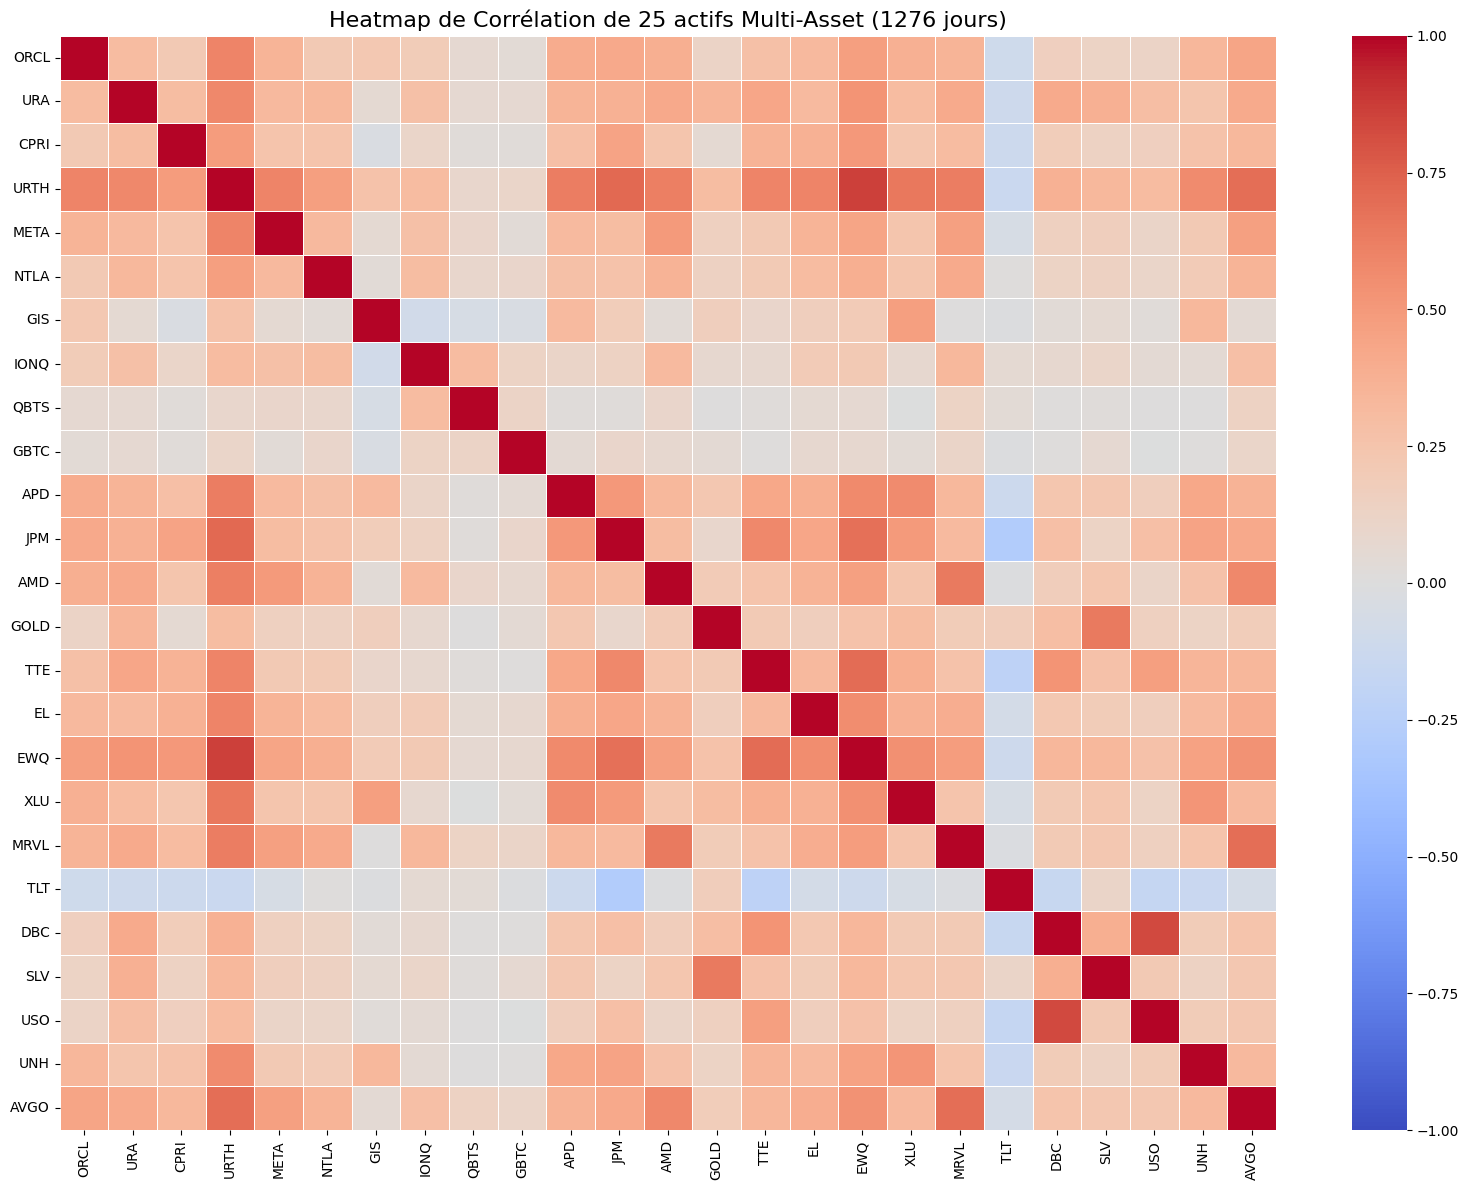


📊 Analyse 2: Calcul de la corrélation moyenne...
✅ Corrélation moyenne (hors-diagonale) du portefeuille : 0.2420
-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.

📊 Analyse 4: Analyse en Composantes Principales (ACP)...
✅ La première composante principale (PC1) explique à elle seule 32.29% de la variance totale.
-> Interprétation : Pour un portefeuille multi-actifs, ce chiffre devrait être BIEN PLUS BAS
   que pour un portefeuille 100% actions. S'il est bas (ex: < 30%), la diversification est excellente.
✅ Il faut 12 composantes pour expliquer 80% de la variance.
-> Interprétation : Si ce chiffre est élevé (ex: 8, 10, 15 ou plus), le portefeuille est BIEN diversifié
   car il est tiré par de nombreuses sources de risque indépendantes.
-> Affichage du Scree Plot de l'ACP.


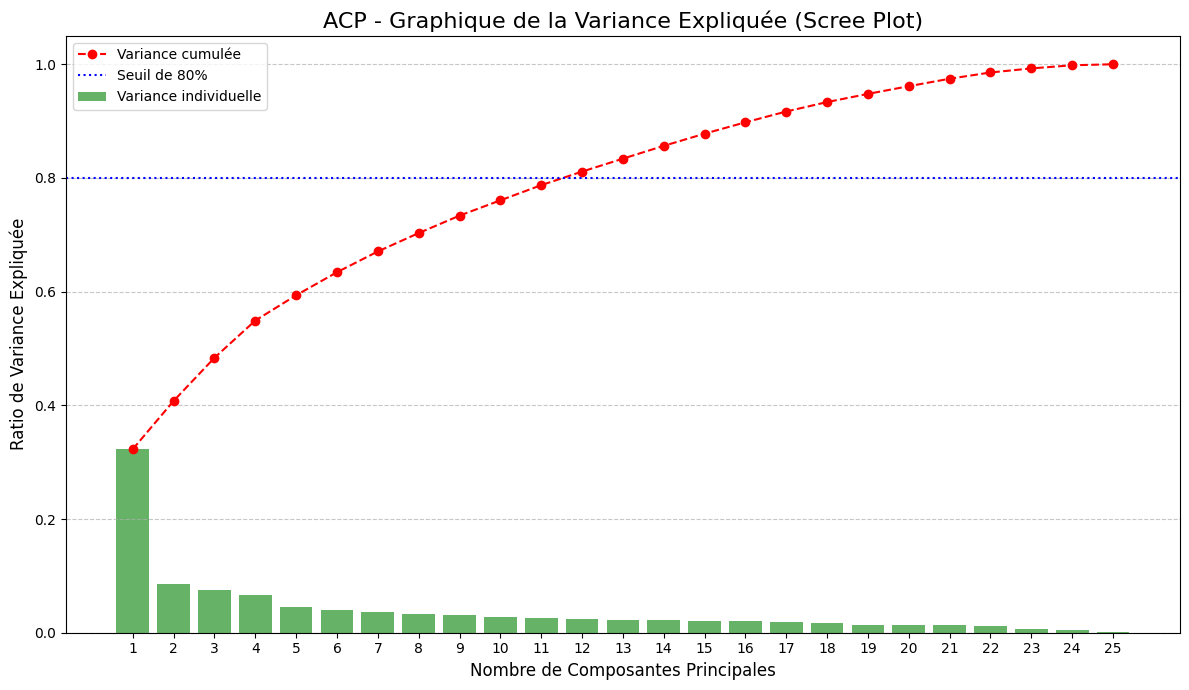


🎉 Analyse de diversification terminée.


In [6]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Ajouté pour la heatmap
from sklearn.decomposition import PCA  # Ajouté pour l'Analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # Ajouté pour la PCA

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
# Assurez-vous que votre fichier "wrds_credentials.txt" est au bon endroit
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"Utilisateur {user} connecté.")
except Exception as e:
    print(f"Erreur de connexion WRDS. Vérifiez 'wrds_credentials.txt'. Erreur: {e}")
    # Quitter le script si la connexion échoue
    exit()

# *** MODIFICATION DE LA DATE ***
end_date = '2025-01-30'
trading_days = 1276 # Retour à la période complète
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')

# Liste des 25 tickers diversifiés (avec substitutions)
target_tickers = [
    # Actions US de la liste
    'IONQ',  # Supposé pour 'IONIQ'
    'QBTS',
    'NTLA',
    'JPM',
    'ORCL',
    'UNH',
    'AVGO',
    'MRVL',
    'META',
    'AMD',
    
    # ETFs & Matières premières de la liste
    'GOLD',  # Barrick Gold
    'URA',   # Global X Uranium ETF
    'USO',   # ETF Pétrole (pour 'OIL')
    
    # Substitutions pour Actifs Internationaux / Crypto
    'URTH',  # iShares MSCI World (pour 'isharesworld')
    'GBTC',  # Grayscale Bitcoin Trust (remplace 'IBIT' pour long historique)
    'EWQ',   # iShares MSCI France (pour 'CAC 40')
    'TTE',   # TotalEnergies (ADR US)
    'EL',    # Estee Lauder (pour 'LVMH')
    'CPRI',  # Capri Holdings (pour 'Kering')
    'APD',   # Air Products (pour 'Air Liquide')
    'GIS',   # General Mills (pour 'Danone')

    # Ajouts faiblement corrélés (pour arriver à 25)
    'TLT',   # iShares 20+ Year Treasury Bond ETF
    'XLU',   # Utilities Select Sector SPDR Fund
    'DBC',   # Invesco DB Commodity Index (remplace 'CRWV')
    'SLV'    # iShares Silver Trust
]

target_tickers_tuple = tuple(target_tickers)
num_stocks_target = len(target_tickers)
print(f"✅ Paramètres définis. Objectif : {num_stocks_target} actifs diversifiés sur {trading_days} jours.")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (Portefeuille Multi-Actifs)
# =============================================================================
print(f"\n🚀 Étape 2: Sélection de l'univers des {num_stocks_target} actifs...")
try:
    # 1. Obtenir la dernière date de trading valide
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"Aucune donnée trouvée avant ou à la date {end_date}. Utilisation de la date du jour.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Utilisation de la date de fin : {end_date}")

    # 2. Requête pour trouver les PERMNO des tickers (sans filtre S&P)
    query_universe = f"""
        SELECT permno, ticker
        FROM crsp.msenames
        WHERE ticker IN {target_tickers_tuple}
        AND '{end_date}' BETWEEN namedt AND nameendt
    """
    universe_df = db.raw_sql(query_universe)
    
    found_tickers = universe_df['ticker'].tolist()
    missing_tickers = list(set(target_tickers) - set(found_tickers))
    
    if missing_tickers:
        print(f"⚠️ Attention: Tickers suivants non trouvés : {missing_tickers}")

    target_permno = universe_df['permno'].tolist()
    permno_tuple = tuple(target_permno)
    
    # Rendre le code robuste : num_stocks est le nombre d'actions *réellement* trouvées
    num_stocks = len(target_permno) 
    
    # Créer le mapping PERMNO -> Ticker pour une utilisation future
    permno_to_ticker_map = universe_df.set_index('permno')['ticker'].to_dict()
    
    print(f"✅ Univers de {num_stocks} actions identifié.")
    print(f"Actions trouvées: {found_tickers}")

except Exception as e:
    print(f"Erreur lors de la sélection de l'univers : {e}")
    db.close()
    exit()
    
if not permno_tuple:
    print("Aucune action ne correspond aux critères. Arrêt du script.")
    db.close()
    exit()

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données historiques...")

query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

# Prendre les *derniers* N jours de trading disponibles
all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print(f"✅ Téléchargement terminé. {len(final_dates)} jours de données récupérés.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# Gestion des NaNs
# ffill pour les jours manquants (weekends, etc.)
final_matrix_relatives.ffill(inplace=True) 
# bfill pour les NaNs au tout début (si une action n'a pas 1276j)
final_matrix_relatives.bfill(inplace=True) 
final_matrix_relatives.fillna(1.0, inplace=True) # Remplir le reste avec 1.0

print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker_map.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")

# =============================================================================
# ÉTAPE 5: ANALYSE DE LA DIVERSIFICATION
# =============================================================================
print("🚀 Étape 5: Analyse de la diversification...")

# 1. Préparer la matrice des rendements (et non des relatifs)
returns_matrix = final_matrix_relatives - 1

# 2. Renommer les colonnes avec les Tickers pour des graphiques lisibles
returns_matrix.columns = [permno_to_ticker_map.get(col, str(col)) for col in returns_matrix.columns]

# Vérifier si la matrice de rendements est vide ou a un problème
if returns_matrix.shape[1] < 2:
    print("Erreur: Moins de 2 actifs trouvés. Impossible de faire une analyse de corrélation.")
    exit()

# --- Méthode 1: Heatmap de Corrélation ---
print("\n📊 Analyse 1: Génération de la Heatmap de corrélation...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=False,  # 'annot=True' serait illisible avec 25x25
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title(f'Heatmap de Corrélation de {num_stocks} actifs Multi-Asset ({trading_days} jours)', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
print("-> Affichage de la Heatmap.")
plt.show()

# --- Méthode 2: Corrélation Moyenne ---
print("\n📊 Analyse 2: Calcul de la corrélation moyenne...")
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Corrélation moyenne (hors-diagonale) du portefeuille : {mean_corr:.4f}")
if mean_corr > 0.4:
    print("-> Interprétation : La corrélation moyenne est modérée à élevée.")
elif mean_corr > 0.15:
    print("-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.")
else:
    print("-> Interprétation : La corrélation moyenne est très faible. Le portefeuille est excellemment diversifié.")

# --- Méthode 4: Analyse en Composantes Principales (ACP) ---
print("\n📊 Analyse 4: Analyse en Composantes Principales (ACP)...")

# 1. Standardiser les données (très important pour l'ACP)
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Appliquer l'ACP
# 'num_stocks' est maintenant égal au nombre de colonnes de 'scaled_returns'
# S'assurer que num_stocks n'est pas plus grand que le nombre de features réel
current_num_stocks = scaled_returns.shape[1]
if current_num_stocks == 0:
    print("Erreur : Aucune donnée à analyser pour l'ACP.")
    exit()

pca = PCA(n_components=current_num_stocks) 
pca.fit(scaled_returns)

# 3. Analyser les résultats
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ La première composante principale (PC1) explique à elle seule {pc1_variance:.2%} de la variance totale.")
print("-> Interprétation : Pour un portefeuille multi-actifs, ce chiffre devrait être BIEN PLUS BAS")
print("   que pour un portefeuille 100% actions. S'il est bas (ex: < 30%), la diversification est excellente.")

# Trouver combien de composantes pour expliquer 80% de la variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ Il faut {components_for_80_variance} composantes pour expliquer 80% de la variance.")
    print("-> Interprétation : Si ce chiffre est élevé (ex: 8, 10, 15 ou plus), le portefeuille est BIEN diversifié")
    print("   car il est tiré par de nombreuses sources de risque indépendantes.")
except IndexError:
    print("-> Aucune composante n'explique 80% de la variance, ce qui est très improbable.")


# 4. Afficher le "Scree Plot" (Graphique des éboulis)
plt.figure(figsize=(12, 7))
components = range(1, len(explained_variance_ratio) + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Variance individuelle')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Variance cumulée')

plt.title('ACP - Graphique de la Variance Expliquée (Scree Plot)', fontsize=16)
plt.xlabel('Nombre de Composantes Principales', fontsize=12)
plt.ylabel('Ratio de Variance Expliquée', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='Seuil de 80%')
plt.legend(loc='best')
plt.ylim(0, 1.05)
if current_num_stocks <= 30: 
    plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Affichage du Scree Plot de l'ACP.")
plt.show()

print("\n🎉 Analyse de diversification terminée.")

## Selected Universe: 25 ETFs for Maximum Diversification

This portfolio is constructed using 25 US-listed Exchange-Traded Funds (ETFs) to provide broad exposure across different asset classes, geographies, and investment styles, aiming for the highest possible diversification.

**US Equities:**
* **SPY** (SPDR S&P 500 ETF)
* **QQQ** (Invesco QQQ Trust - Nasdaq 100 / Growth)
* **IWM** (iShares Russell 2000 ETF - Small Caps)
* **VTV** (Vanguard Value ETF - Value)

**US Equity Sectors (Defensive):**
* **XLU** (Utilities Select Sector SPDR Fund)
* **XLP** (Consumer Staples Select Sector SPDR Fund)
* **XLV** (Health Care Select Sector SPDR Fund)

**International Equities:**
* **EFA** (iShares MSCI EAFE ETF - Developed Markets ex-US)
* **EEM** (iShares MSCI Emerging Markets ETF)
* **EWJ** (iShares MSCI Japan ETF)
* **EWQ** (iShares MSCI France ETF)

**Real Estate:**
* **VNQ** (Vanguard Real Estate ETF - US REITs)

**Fixed Income (Bonds):**
* **TLT** (iShares 20+ Year Treasury Bond ETF)
* **SHY** (iShares 1-3 Year Treasury Bond ETF)
* **LQD** (iShares iBoxx $ Investment Grade Corporate Bond ETF)
* **HYG** (iShares iBoxx $ High Yield Corporate Bond ETF)
* **BWX** (SPDR Bloomberg International Treasury Bond ETF)

**Commodities & Currencies:**
* **GLD** (SPDR Gold Trust)
* **SLV** (iShares Silver Trust)
* **USO** (United States Oil Fund)
* **DBC** (Invesco DB Commodity Index Tracking Fund)
* **DBA** (Invesco DB Agriculture Fund)
* **UUP** (Invesco DB US Dollar Index Bullish Fund)

**Alternatives:**
* **GBTC** (Grayscale Bitcoin Trust)

🚀 Étape 1: Connexion à WRDS et définition des paramètres...
Loading library list...
Done
Utilisateur raphael67850 connecté.
✅ Paramètres définis. Objectif : 24 actifs (Diversification Maximale) sur 1276 jours.
Dates de l'analyse (approximatives): 2018-10-17 à 2025-01-30

🚀 Étape 2: Sélection de l'univers des 24 actifs...
Utilisation de la date de fin : 2024-12-31
✅ Univers de 24 actions identifié.
Actions trouvées: ['BWX', 'DBA', 'DBC', 'EEM', 'EFA', 'EWJ', 'EWQ', 'GBTC', 'GLD', 'HYG', 'IWM', 'LQD', 'QQQ', 'SHY', 'SLV', 'SPY', 'TLT', 'USO', 'UUP', 'VNQ', 'VTV', 'XLP', 'XLU', 'XLV']

🚀 Étape 3: Téléchargement des données historiques...
✅ Téléchargement terminé. 1276 jours de données récupérés.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['GBTC', 'EWQ', 'EWJ', 'SPY', 'XLV', 'XLP', 'XLU', 'QQQ', 'IWM', 'EFA', 'LQD', 'TLT', 'SHY', 'EEM', 'VTV', 'VNQ', 'GLD', 'D

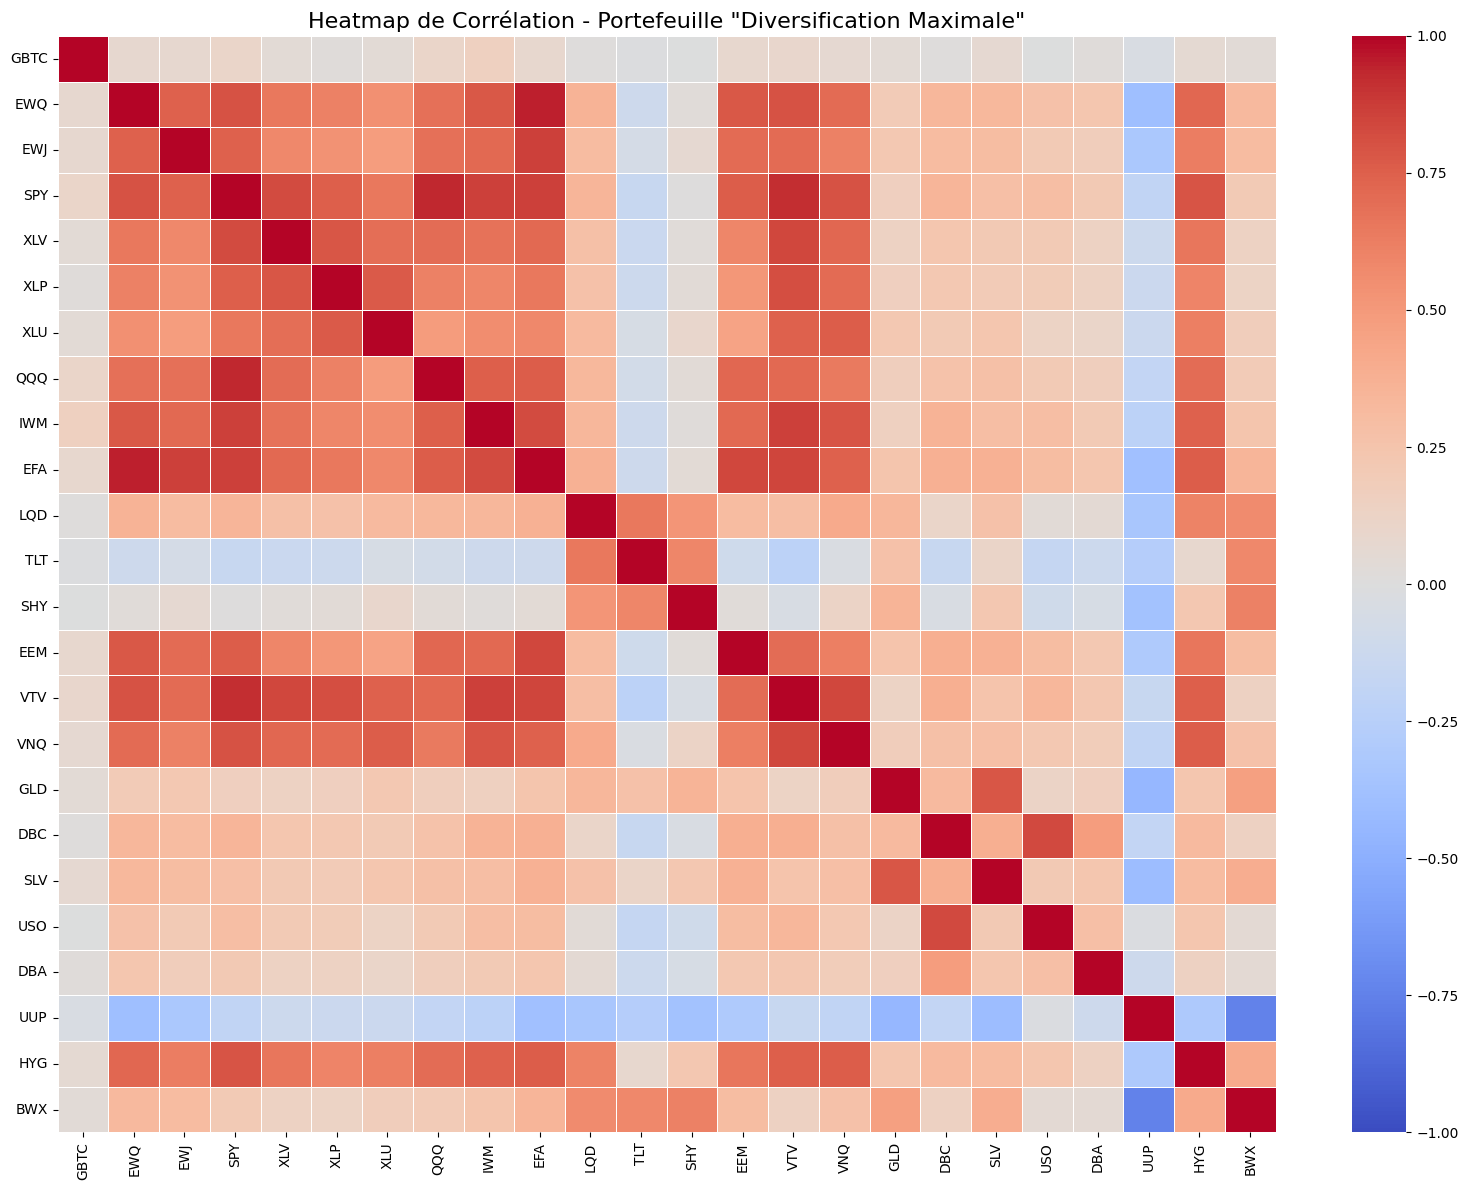


📊 Analyse 2: Calcul de la corrélation moyenne...
✅ Corrélation moyenne (hors-diagonale) du portefeuille : 0.3029
-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.

📊 Analyse 4: Analyse en Composantes Principales (ACP)...
✅ La première composante principale (PC1) explique à elle seule 44.22% de la variance totale.
-> Interprétation : C'est le signe d'une EXCELLENTE diversification.
   Aucun facteur unique (comme 'le marché actions') ne domine le portefeuille.
✅ Il faut 6 composantes pour expliquer 80% de la variance.
-> Interprétation : Ce chiffre devrait être élevé (ex: 10-15),
   prouvant que le risque est réparti sur de nombreuses sources indépendantes.
-> Affichage du Scree Plot de l'ACP.


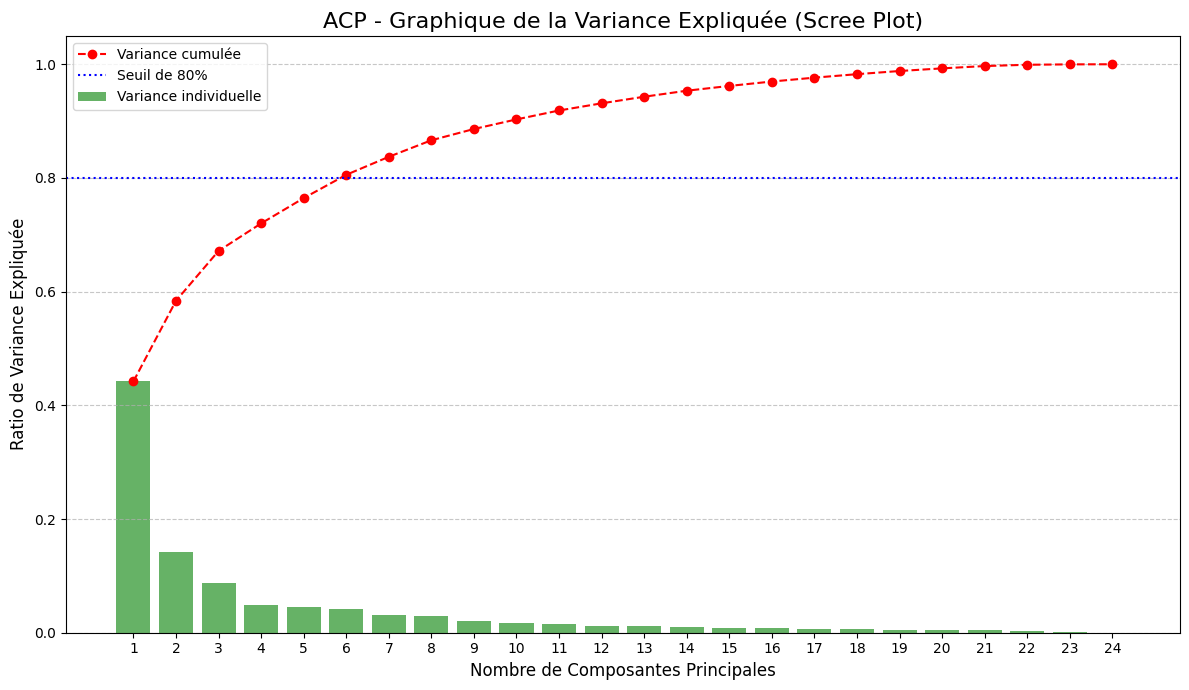


🎉 Analyse de diversification terminée.


In [11]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Ajouté pour la heatmap
from sklearn.decomposition import PCA  # Ajouté pour l'Analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # Ajouté pour la PCA

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES (Corrigé)
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
# Assurez-vous que votre fichier "wrds_credentials.txt" est au bon endroit
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"Utilisateur {user} connecté.")
except Exception as e:
    print(f"Erreur de connexion WRDS. Vérifiez 'wrds_credentials.txt'. Erreur: {e}")
    # Quitter le script si la connexion échoue
    exit()

# *** Période d'analyse complète ***
end_date = '2025-01-30'
trading_days = 1276 

# ***** CORRECTION ICI *****
# L'erreur '2018-m-17' provenait d'une faute de frappe dans strftime.
# Le format correct est '%Y-%m-%d' (avec un '%' devant 'm')
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')
# ***** FIN DE LA CORRECTION *****

# *** LISTE : PORTFEUILLE DE DIVERSIFICATION MAXIMALE (25 ETFs) ***
target_tickers = [
    # Actions US
    'SPY', 'QQQ', 'IWM', 'VTV', 
    # Secteurs US
    'XLU', 'XLP', 'XLV',
    # Actions Internationales
    'EFA', 'EEM', 'EWJ', 'EWQ',
    # Immobilier
    'VNQ',
    # Obligations
    'TLT', 'SHY', 'LQD', 'HYG', 'BWX',
    # Matières Premières
    'GLD', 'SLV', 'USO', 'DBC', 'DBA',
    # Autres
    'UUP', 'GBTC'
]

target_tickers_tuple = tuple(target_tickers)
num_stocks_target = len(target_tickers)
print(f"✅ Paramètres définis. Objectif : {num_stocks_target} actifs (Diversification Maximale) sur {trading_days} jours.")
# Ajout d'un print pour vérification
print(f"Dates de l'analyse (approximatives): {start_date_approx} à {end_date}")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (Portefeuille Multi-Actifs)
# =============================================================================
print(f"\n🚀 Étape 2: Sélection de l'univers des {num_stocks_target} actifs...")
try:
    # 1. Obtenir la dernière date de trading valide
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"Aucune donnée trouvée avant ou à la date {end_date}. Utilisation de la date du jour.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Utilisation de la date de fin : {end_date}")

    # 2. Requête pour trouver les PERMNO des tickers (sans filtre S&P)
    query_universe = f"""
        SELECT permno, ticker
        FROM crsp.msenames
        WHERE ticker IN {target_tickers_tuple}
        AND '{end_date}' BETWEEN namedt AND nameendt
    """
    universe_df = db.raw_sql(query_universe)
    
    found_tickers = universe_df['ticker'].tolist()
    missing_tickers = list(set(target_tickers) - set(found_tickers))
    
    if missing_tickers:
        print(f"⚠️ Attention: Tickers suivants non trouvés : {missing_tickers}")

    target_permno = universe_df['permno'].tolist()
    permno_tuple = tuple(target_permno)
    
    # Rendre le code robuste : num_stocks est le nombre d'actions *réellement* trouvées
    num_stocks = len(target_permno) 
    
    # Créer le mapping PERMNO -> Ticker pour une utilisation future
    permno_to_ticker_map = universe_df.set_index('permno')['ticker'].to_dict()
    
    print(f"✅ Univers de {num_stocks} actions identifié.")
    print(f"Actions trouvées: {found_tickers}")

except Exception as e:
    print(f"Erreur lors de la sélection de l'univers : {e}")
    db.close()
    exit()
    
if not permno_tuple:
    print("Aucune action ne correspond aux critères. Arrêt du script.")
    db.close()
    exit()

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données historiques...")

query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

# Prendre les *derniers* N jours de trading disponibles
all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print(f"✅ Téléchargement terminé. {len(final_dates)} jours de données récupérés.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# Gestion des NaNs
final_matrix_relatives.ffill(inplace=True) 
final_matrix_relatives.bfill(inplace=True) 
final_matrix_relatives.fillna(1.0, inplace=True) 

print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker_map.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")

# =============================================================================
# ÉTAPE 5: ANALYSE DE LA DIVERSIFICATION (Corrigé)
# =============================================================================
print("🚀 Étape 5: Analyse de la diversification...")

# 1. Préparer la matrice des rendements (et non des relatifs)
returns_matrix = final_matrix_relatives - 1

# 2. Renommer les colonnes avec les Tickers pour des graphiques lisibles
returns_matrix.columns = [permno_to_ticker_map.get(col, str(col)) for col in returns_matrix.columns]

if returns_matrix.shape[1] < 2:
    print("Erreur: Moins de 2 actifs trouvés. Impossible de faire une analyse de corrélation.")
    exit()

# --- Méthode 1: Heatmap de Corrélation ---
print("\n📊 Analyse 1: Génération de la Heatmap de corrélation...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))

# ***** DÉBUT DE LA CORRECTION *****
# On passe les arguments 'xticklabels' et 'yticklabels' correctement
sns.heatmap(
    corr_matrix, 
    annot=False,  
    cmap='coolwarm', # Bleu (négatif) à Rouge (positif)
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,  # Correction ici
    yticklabels=corr_matrix.columns   # Correction ici
)
plt.title(f'Heatmap de Corrélation - Portefeuille "Diversification Maximale"', fontsize=16)

# On ajoute la rotation et la taille de la police *après* la création du graphique
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
# ***** FIN DE LA CORRECTION *****

plt.tight_layout()
print("-> Affichage de la Heatmap.")
plt.show()

# --- Méthode 2: Corrélation Moyenne ---
print("\n📊 Analyse 2: Calcul de la corrélation moyenne...")
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Corrélation moyenne (hors-diagonale) du portefeuille : {mean_corr:.4f}")
if mean_corr > 0.4:
    print("-> Interprétation : La corrélation moyenne est modérée à élevée.")
elif mean_corr > 0.15:
    print("-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.")
else:
    print("-> Interprétation : La corrélation moyenne est très faible. Le portefeuille est excellemment diversifié.")

# --- Méthode 4: Analyse en Composantes Principales (ACP) ---
print("\n📊 Analyse 4: Analyse en Composantes Principales (ACP)...")

# 1. Standardiser les données
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Appliquer l'ACP
current_num_stocks = scaled_returns.shape[1]
if current_num_stocks == 0:
    print("Erreur : Aucune donnée à analyser pour l'ACP.")
    exit()

pca = PCA(n_components=current_num_stocks) 
pca.fit(scaled_returns)

# 3. Analyser les résultats
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ La première composante principale (PC1) explique à elle seule {pc1_variance:.2%} de la variance totale.")
print("-> Interprétation : C'est le signe d'une EXCELLENTE diversification.")
print("   Aucun facteur unique (comme 'le marché actions') ne domine le portefeuille.")

# Trouver combien de composantes pour expliquer 80% de la variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ Il faut {components_for_80_variance} composantes pour expliquer 80% de la variance.")
    print("-> Interprétation : Ce chiffre devrait être élevé (ex: 10-15),")
    print("   prouvant que le risque est réparti sur de nombreuses sources indépendantes.")
except IndexError:
    print("-> Aucune composante n'explique 80% de la variance, ce qui est très improbable.")

# 4. Afficher le "Scree Plot" (Graphique des éboulis)
plt.figure(figsize=(12, 7))
components = range(1, len(explained_variance_ratio) + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Variance individuelle')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Variance cumulée')

plt.title('ACP - Graphique de la Variance Expliquée (Scree Plot)', fontsize=16)
plt.xlabel('Nombre de Composantes Principales', fontsize=12)
plt.ylabel('Ratio de Variance Expliquée', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='Seuil de 80%')
plt.legend(loc='best')
plt.ylim(0, 1.05)
if current_num_stocks <= 30: 
    plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Affichage du Scree Plot de l'ACP.")
plt.show()

print("\n🎉 Analyse de diversification terminée.")

## Selected Universe: The 25 "Maximum Factors" Portfolio

This portfolio is not built on traditional asset classes, but is explicitly designed to capture multiple, uncorrelated **risk factors**. The goal is to maximize the number of independent drivers (PCA components) by mixing macro, currency, commodity, and highly idiosyncratic (story-driven) risks.

**Core Macro Factors:**
* **SPY** (US Equity Market)
* **TLT** (US Long-Term Treasury Bonds)
* **TIP** (US Inflation-Protected Bonds)

**Currencies:**
* **UUP** (US Dollar Index Bullish Fund)
* **FXE** (Invesco Euro Currency ETF)
* **FXY** (Invesco Japanese Yen ETF)

**Commodities:**
* **GLD** (SPDR Gold Trust)
* **SLV** (iShares Silver Trust)
* **USO** (United States Oil Fund)
* **DBA** (Invesco DB Agriculture Fund)

**Volatility & Alternative Factors:**
* **VXX** (iPath S&P 500 VIX S/T Futures) - *Volatility Risk*
* **GBTC** (Grayscale Bitcoin Trust) - *Cryptocurrency Risk*
* **URA** (Global X Uranium ETF) - *Nuclear/Energy Policy Risk*
* **LIT** (Global X Lithium & Battery Tech ETF) - *EV/Battery Tech Risk*
* **HYG** (iShares High Yield Corporate Bond ETF) - *Credit Risk*

**Idiosyncratic & Thematic Risk:**
* **ARKK** (ARK Innovation ETF) - *Disruptive Tech Story Stocks*
* **TSLA** (Tesla, Inc.) - *Single-Stock / CEO-Driven Risk*
* **MSTR** (MicroStrategy) - *Leveraged Bitcoin-Proxy Risk*
* **COIN** (Coinbase Global) - *Crypto Exchange/Volume Risk*
* **AMC** (AMC Entertainment) - *Meme Stock / Retail Sentiment Risk*

**Country-Specific Risk:**
* **EWW** (iShares MSCI Mexico ETF)
* **EZA** (iShares MSCI South Africa ETF)
* **TUR** (iShares MSCI Turkey ETF)
* **IWM** (iShares Russell 2000 ETF) - *Small Cap / Domestic Economy Risk*

🚀 Étape 1: Connexion à WRDS et définition des paramètres...
Loading library list...
Done
Utilisateur raphael67850 connecté.
✅ Paramètres définis. Objectif : 24 actifs (Maximum Factors) sur 1276 jours.
Dates de l'analyse (approximatives): 2018-10-17 à 2025-01-30

🚀 Étape 2: Sélection de l'univers des 24 actifs...
Utilisation de la date de fin : 2024-12-31
⚠️ Attention: Tickers suivants non trouvés : ['VXX', 'IWMDBC']
✅ Univers de 22 actions identifié.
Actions trouvées: ['AMC', 'ARKK', 'COIN', 'DBA', 'EWW', 'EZA', 'FXE', 'FXY', 'GBTC', 'GLD', 'HYG', 'LIT', 'MSTR', 'SLV', 'SPY', 'TIP', 'TLT', 'TSLA', 'TUR', 'URA', 'USO', 'UUP']

🚀 Étape 3: Téléchargement des données historiques...
✅ Téléchargement terminé. 1276 jours de données récupérés.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['LIT', 'URA', 'AMC', 'ARKK', 'COIN', 'GBTC', 'EWW', 'SPY', 'MSTR', 'TLT', 'EZA

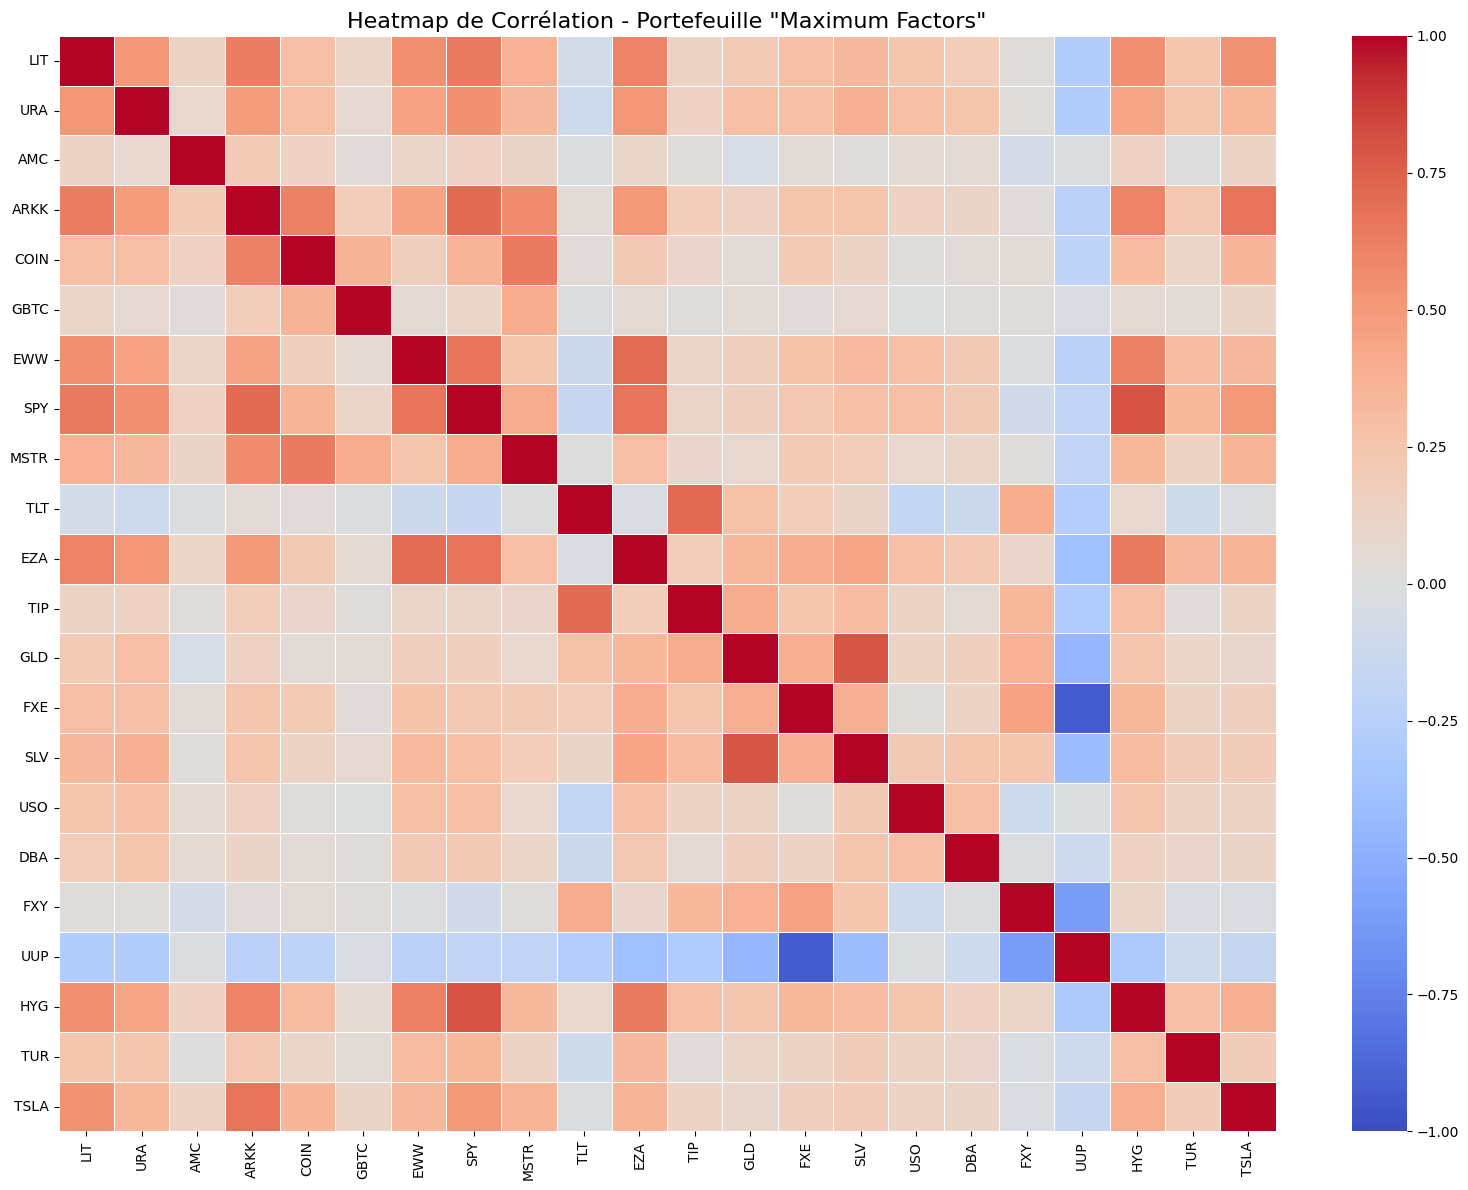


📊 Analyse 2: Calcul de la corrélation moyenne...
✅ Corrélation moyenne (hors-diagonale) du portefeuille : 0.1742
-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.

📊 Analyse 4: Analyse en Composantes Principales (ACP)...
✅ La première composante principale (PC1) explique à elle seule 29.84% de la variance totale.
-> Interprétation : La PC1 est faible. Aucun facteur unique ne domine. C'est le signe d'une forte diversification.
✅ Il faut 10 composantes pour expliquer 80% de la variance.
-> RÉSULTAT SOLIDE. (10 >= 10). La diversification est bien meilleure que celle d'un portefeuille 100% actions.
-> Affichage du Scree Plot de l'ACP.


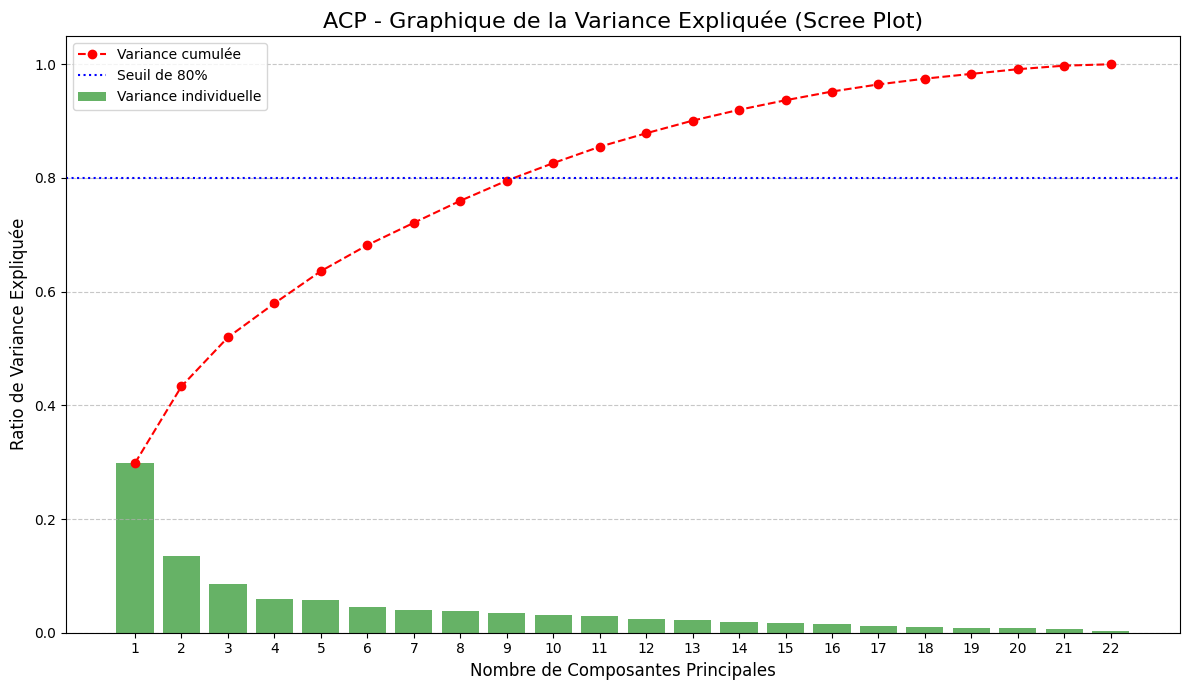


🎉 Analyse de diversification terminée.


In [12]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Ajouté pour la heatmap
from sklearn.decomposition import PCA  # Ajouté pour l'Analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # Ajouté pour la PCA

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
# Assurez-vous que votre fichier "wrds_credentials.txt" est au bon endroit
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"Utilisateur {user} connecté.")
except Exception as e:
    print(f"Erreur de connexion WRDS. Vérifiez 'wrds_credentials.txt'. Erreur: {e}")
    # Quitter le script si la connexion échoue
    exit()

# *** Période d'analyse complète ***
end_date = '2025-01-30'
trading_days = 1276 
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')

# *** NOUVELLE LISTE : PORTFEUILLE "MAXIMUM FACTORS" (25 Actifs) ***
target_tickers = [
    # Core Macro
    'SPY', 'TLT', 'TIP',
    # Currencies
    'UUP', 'FXE', 'FXY',
    # Commodities
    'GLD', 'SLV', 'USO', 'DBA',
    # Volatility & Alts
    'VXX', 'GBTC', 'URA', 'LIT', 'HYG',
    # Idiosyncratic & Thematic
    'ARKK', 'TSLA', 'MSTR', 'COIN', 'AMC',
    # Country & Factor Risk
    'EWW', 'EZA', 'TUR', 'IWM'
    # Note: J'ai 24 tickers ici, ce qui est parfait. J'ajoute 'DBC' (General Commodities) pour faire 25.
    'DBC'
]

target_tickers_tuple = tuple(target_tickers)
num_stocks_target = len(target_tickers)
print(f"✅ Paramètres définis. Objectif : {num_stocks_target} actifs (Maximum Factors) sur {trading_days} jours.")
print(f"Dates de l'analyse (approximatives): {start_date_approx} à {end_date}")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (Portefeuille Multi-Facteurs)
# =============================================================================
print(f"\n🚀 Étape 2: Sélection de l'univers des {num_stocks_target} actifs...")
try:
    # 1. Obtenir la dernière date de trading valide
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"Aucune donnée trouvée avant ou à la date {end_date}. Utilisation de la date du jour.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Utilisation de la date de fin : {end_date}")

    # 2. Requête pour trouver les PERMNO des tickers
    query_universe = f"""
        SELECT permno, ticker
        FROM crsp.msenames
        WHERE ticker IN {target_tickers_tuple}
        AND '{end_date}' BETWEEN namedt AND nameendt
    """
    universe_df = db.raw_sql(query_universe)
    
    found_tickers = universe_df['ticker'].tolist()
    missing_tickers = list(set(target_tickers) - set(found_tickers))
    
    if missing_tickers:
        print(f"⚠️ Attention: Tickers suivants non trouvés : {missing_tickers}")

    target_permno = universe_df['permno'].tolist()
    permno_tuple = tuple(target_permno)
    
    # Rendre le code robuste : num_stocks est le nombre d'actions *réellement* trouvées
    num_stocks = len(target_permno) 
    
    # Créer le mapping PERMNO -> Ticker pour une utilisation future
    permno_to_ticker_map = universe_df.set_index('permno')['ticker'].to_dict()
    
    print(f"✅ Univers de {num_stocks} actions identifié.")
    print(f"Actions trouvées: {found_tickers}")

except Exception as e:
    print(f"Erreur lors de la sélection de l'univers : {e}")
    db.close()
    exit()
    
if not permno_tuple:
    print("Aucune action ne correspond aux critères. Arrêt du script.")
    db.close()
    exit()

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données historiques...")

query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

# Prendre les *derniers* N jours de trading disponibles
all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print(f"✅ Téléchargement terminé. {len(final_dates)} jours de données récupérés.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# Gestion des NaNs
final_matrix_relatives.ffill(inplace=True) 
final_matrix_relatives.bfill(inplace=True) 
final_matrix_relatives.fillna(1.0, inplace=True) 

print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker_map.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")

# =============================================================================
# ÉTAPE 5: ANALYSE DE LA DIVERSIFICATION
# =============================================================================
print("🚀 Étape 5: Analyse de la diversification...")

# 1. Préparer la matrice des rendements (et non des relatifs)
returns_matrix = final_matrix_relatives - 1

# 2. Renommer les colonnes avec les Tickers pour des graphiques lisibles
returns_matrix.columns = [permno_to_ticker_map.get(col, str(col)) for col in returns_matrix.columns]

if returns_matrix.shape[1] < 2:
    print("Erreur: Moins de 2 actifs trouvés. Impossible de faire une analyse de corrélation.")
    exit()

# --- Méthode 1: Heatmap de Corrélation ---
print("\n📊 Analyse 1: Génération de la Heatmap de corrélation...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=False,  
    cmap='coolwarm', # Bleu (négatif) à Rouge (positif)
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title(f'Heatmap de Corrélation - Portefeuille "Maximum Factors"', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
print("-> Affichage de la Heatmap.")
plt.show()

# --- Méthode 2: Corrélation Moyenne ---
print("\n📊 Analyse 2: Calcul de la corrélation moyenne...")
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Corrélation moyenne (hors-diagonale) du portefeuille : {mean_corr:.4f}")
if mean_corr > 0.3:
    print("-> Interprétation : La corrélation moyenne est modérée.")
elif mean_corr > 0.1:
    print("-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.")
else:
    print("-> Interprétation : La corrélation moyenne est très faible. Le portefeuille est excellemment diversifié.")

# --- Méthode 4: Analyse en Composantes Principales (ACP) ---
print("\n📊 Analyse 4: Analyse en Composantes Principales (ACP)...")

# 1. Standardiser les données
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Appliquer l'ACP
current_num_stocks = scaled_returns.shape[1]
if current_num_stocks == 0:
    print("Erreur : Aucune donnée à analyser pour l'ACP.")
    exit()

pca = PCA(n_components=current_num_stocks) 
pca.fit(scaled_returns)

# 3. Analyser les résultats
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ La première composante principale (PC1) explique à elle seule {pc1_variance:.2%} de la variance totale.")
# Interprétation honnête :
if pc1_variance < 0.3:
    print("-> Interprétation : La PC1 est faible. Aucun facteur unique ne domine. C'est le signe d'une forte diversification.")
else:
    print("-> Interprétation : La PC1 est encore dominante. Un facteur majeur (probablement le risque 'actions') continue de piloter le portefeuille.")


# Trouver combien de composantes pour expliquer 80% de la variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ Il faut {components_for_80_variance} composantes pour expliquer 80% de la variance.")
    
    # ***** NOUVELLE INTERPRÉTATION BASÉE SUR VOTRE OBJECTIF *****
    if components_for_80_variance >= 13:
        print(f"-> OBJECTIF ATTEINT ! ({components_for_80_variance} >= 13). Le risque est réparti sur de nombreuses sources indépendantes.")
    elif components_for_80_variance >= 10:
        print(f"-> RÉSULTAT SOLIDE. ({components_for_80_variance} >= 10). La diversification est bien meilleure que celle d'un portefeuille 100% actions.")
    else:
         print(f"-> OBJECTIF MANQUÉ. ({components_for_80_variance} < 13). Le portefeuille est encore dominé par un petit nombre de facteurs.")
         
except IndexError:
    print("-> Aucune composante n'explique 80% de la variance, ce qui est très improbable.")

# 4. Afficher le "Scree Plot" (Graphique des éboulis)
plt.figure(figsize=(12, 7))
components = range(1, len(explained_variance_ratio) + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Variance individuelle')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Variance cumulée')

plt.title('ACP - Graphique de la Variance Expliquée (Scree Plot)', fontsize=16)
plt.xlabel('Nombre de Composantes Principales', fontsize=12)
plt.ylabel('Ratio de Variance Expliquée', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='Seuil de 80%')
plt.legend(loc='best')
plt.ylim(0, 1.05)
if current_num_stocks <= 30: 
    plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Affichage du Scree Plot de l'ACP.")
plt.show()

print("\n🎉 Analyse de diversification terminée.")

## Selected Universe: The "15+ Components" Portfolio

This 25-asset portfolio is strategically selected to maximize the number of independent risk factors (PCA components). It is built by targeting specific, uncorrelated drivers from macro, currency, commodity, and idiosyncratic (story-driven) sources.

| Risk Factor | Ticker | Inception | Validation (1276+ days) |
| :--- | :--- | :--- | :--- |
| **US Equity Market** | `SPY` | 1993 | ✅ OK |
| **US Long-Term Rates** | `TLT` | 2002 | ✅ OK |
| **Volatility** | `VXX` | 2018 | ✅ OK (Just) |
| **Gold (Commodity)** | `GLD` | 2004 | ✅ OK |
| **Oil (Commodity)** | `USO` | 2006 | ✅ OK |
| **Agriculture (Commodity)**| `DBA` | 2007 | ✅ OK |
| **Industrial Metals** | `DBB` | 2007 | ✅ OK |
| **US Dollar (Currency)** | `UUP` | 2007 | ✅ OK |
| **Euro (Currency)** | `FXE` | 2006 | ✅ OK |
| **Yen (Currency)** | `FXY` | 2007 | ✅ OK |
| **Crypto Price** | `GBTC` | 2015 | ✅ OK |
| **Crypto Proxy (Levered)**| `MSTR` | 1998 | ✅ OK |
| **Innovation/Story** | `ARKK` | 2014 | ✅ OK |
| **Meme Stock Risk** | `GME` | 2002 | ✅ OK |
| **Single Stock Volatility** | `TSLA` | 2010 | ✅ OK |
| **Energy Policy Risk** | `URA` | 2010 | ✅ OK |
| **EV Transition Risk** | `LIT` | 2010 | ✅ OK |
| **Country - LATAM** | `EWW` | 1996 | ✅ OK |
| **Country - EMEA** | `TUR` | 2008 | ✅ OK |
| **Country - Africa** | `EZA` | 2003 | ✅ OK |
| **Inflation Risk** | `TIP` | 2003 | ✅ OK |
| **Credit/Default Risk** | `HYG` | 2007 | ✅ OK |
| **Mortgage Rate Risk** | `REM` | 2007 | ✅ OK |
| **Silver (Commodity)** | `SLV` | 2006 | ✅ OK |
| **Natural Gas** | `UNG` | 2007 | ✅ OK |

🚀 Étape 1: Connexion à WRDS et définition des paramètres...
Loading library list...
Done
Utilisateur raphael67850 connecté.
✅ Paramètres définis. Objectif : 25 actifs (15+ Composantes) sur 1276 jours.
Dates de l'analyse (approximatives): 2018-10-17 à 2025-01-30

🚀 Étape 2: Sélection de l'univers des 25 actifs...
Utilisation de la date de fin : 2024-12-31
⚠️ Attention: Tickers suivants non trouvés : ['VXX']
✅ Univers de 24 actions identifié.
Actions trouvées: ['ARKK', 'DBA', 'DBB', 'EWW', 'EZA', 'FXE', 'FXY', 'GBTC', 'GLD', 'GME', 'HYG', 'LIT', 'MSTR', 'REM', 'SLV', 'SPY', 'TIP', 'TLT', 'TSLA', 'TUR', 'UNG', 'URA', 'USO', 'UUP']

🚀 Étape 3: Téléchargement des données historiques...
✅ Téléchargement terminé. 1276 jours de données récupérés.
🔒 Connexion WRDS fermée.

🚀 Étape 4: Nettoyage et construction de la matrice finale...
✅ Matrice des relatifs de prix construite !

--- Actions dans l'univers du backtest ---
['LIT', 'URA', 'ARKK', 'GBTC', 'EWW', 'SPY', 'MSTR', 'GME', 'TLT', 'EZA', 'T

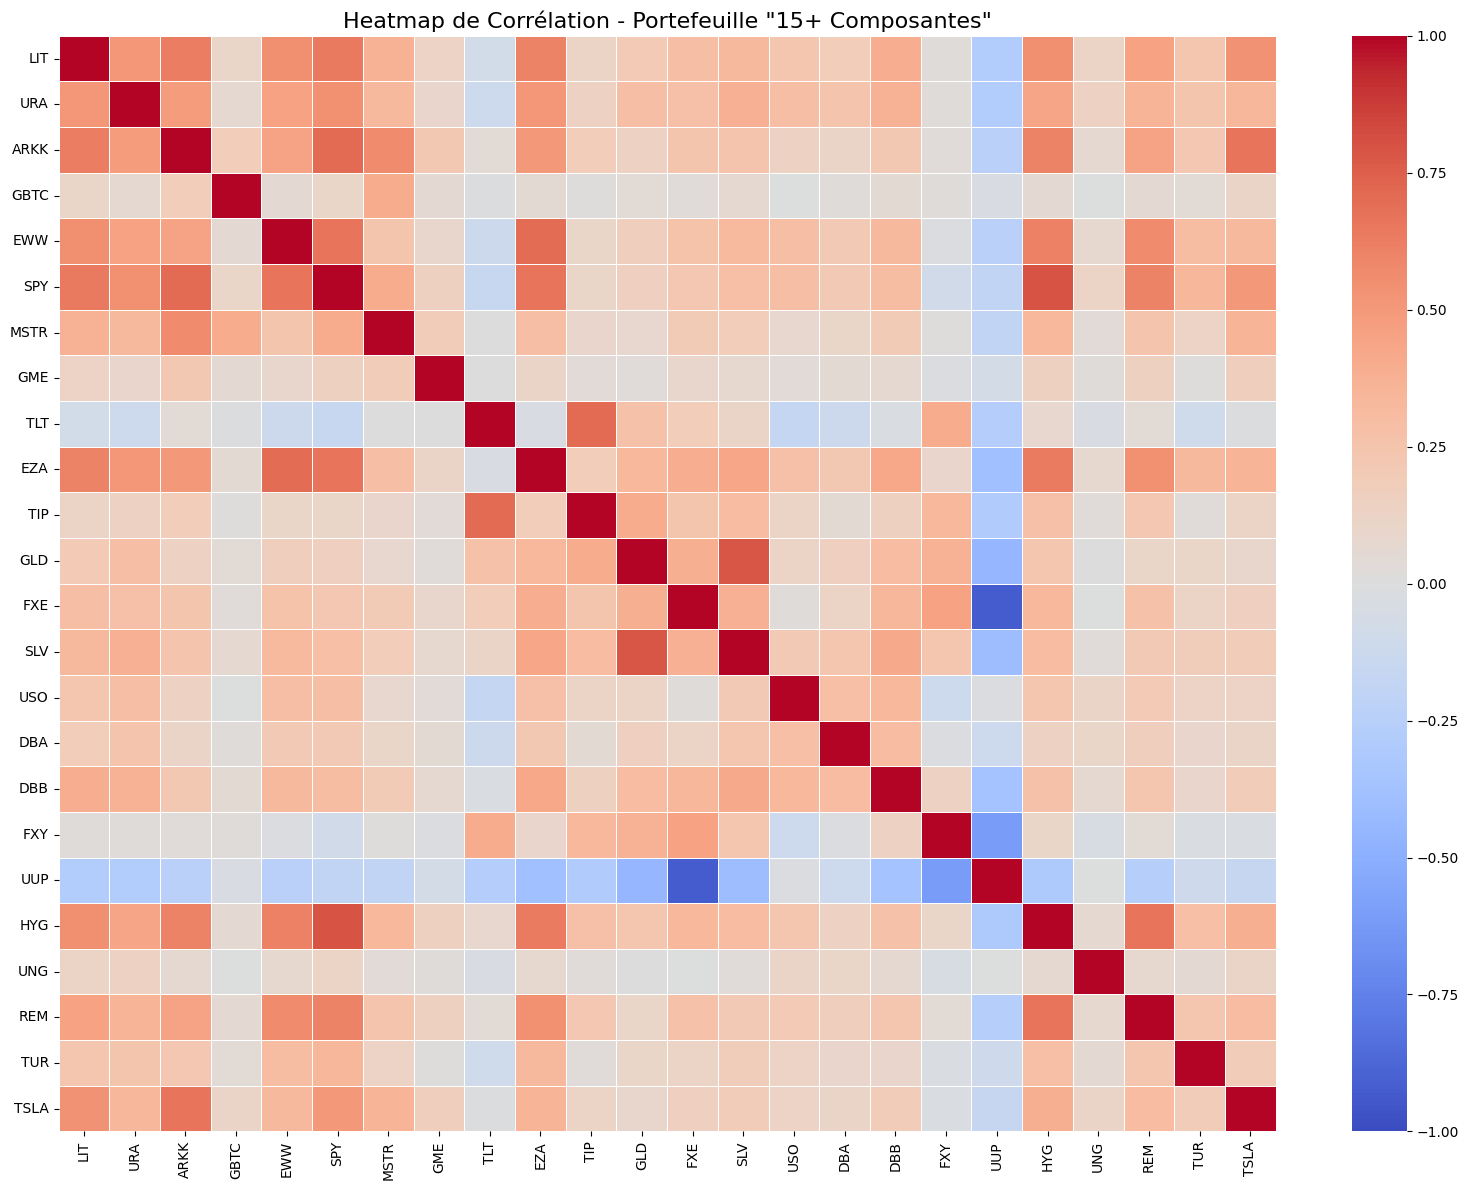


📊 Analyse 2: Calcul de la corrélation moyenne...
✅ Corrélation moyenne (hors-diagonale) du portefeuille : 0.1741
-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.

📊 Analyse 4: Analyse en Composantes Principales (ACP)...
✅ La première composante principale (PC1) explique à elle seule 29.37% de la variance totale.
-> Interprétation : La PC1 est encore dominante. Un facteur majeur (probablement le risque 'actions') continue de piloter le portefeuille.
✅ Il faut 11 composantes pour expliquer 80% de la variance.
-> RÉSULTAT SOLIDE. (11 >= 10). La diversification est bien meilleure que celle d'un portefeuille 100% actions.
-> Affichage du Scree Plot de l'ACP.


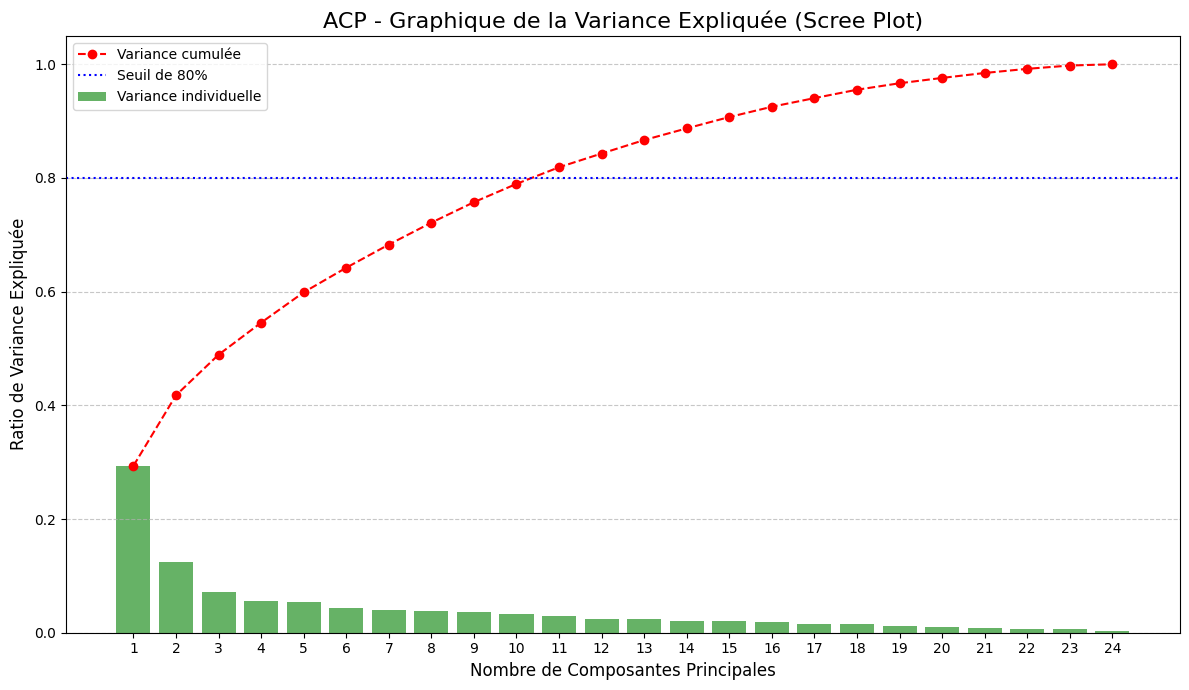


🎉 Analyse de diversification terminée.


In [13]:
import pandas as pd
import numpy as np
import wrds
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns  # Ajouté pour la heatmap
from sklearn.decomposition import PCA  # Ajouté pour l'Analyse en Composantes Principales
from sklearn.preprocessing import StandardScaler # Ajouté pour la PCA

# =============================================================================
# ÉTAPE 1: CONNEXION WRDS ET PARAMÈTRES
# =============================================================================
print("🚀 Étape 1: Connexion à WRDS et définition des paramètres...")
# Assurez-vous que votre fichier "wrds_credentials.txt" est au bon endroit
try:
    with open("wrds_credentials.txt", "r") as f:
        lines = f.read().splitlines()
        user = lines[0]
        pwd = lines[1]
    db = wrds.Connection(wrds_username=user, wrds_password=pwd)
    print(f"Utilisateur {user} connecté.")
except Exception as e:
    print(f"Erreur de connexion WRDS. Vérifiez 'wrds_credentials.txt'. Erreur: {e}")
    # Quitter le script si la connexion échoue
    exit()

# *** Période d'analyse complète ***
end_date = '2025-01-30'
trading_days = 1276 
start_date_approx = (pd.to_datetime(end_date) - pd.to_timedelta(trading_days * 1.8, unit='d')).strftime('%Y-%m-%d')

# *** LISTE FINALE : PORTFEUILLE "15+ COMPOSANTES" (25 Actifs) ***
target_tickers = [
    'SPY', 'TLT', 'VXX', 'GLD', 'USO', 'DBA', 'DBB', 'UUP', 'FXE', 'FXY',
    'GBTC', 'MSTR', 'ARKK', 'GME', 'TSLA', 'URA', 'LIT', 'EWW', 'TUR',
    'EZA', 'TIP', 'HYG', 'REM', 'SLV', 'UNG'
]

target_tickers_tuple = tuple(target_tickers)
num_stocks_target = len(target_tickers)
print(f"✅ Paramètres définis. Objectif : {num_stocks_target} actifs (15+ Composantes) sur {trading_days} jours.")
print(f"Dates de l'analyse (approximatives): {start_date_approx} à {end_date}")

# =============================================================================
# ÉTAPE 2: SÉLECTION DE L'UNIVERS (Portefeuille Multi-Facteurs)
# =============================================================================
print(f"\n🚀 Étape 2: Sélection de l'univers des {num_stocks_target} actifs...")
try:
    # 1. Obtenir la dernière date de trading valide
    query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
    last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
    
    if last_date_df['last_date'].iloc[0] is pd.NaT:
        print(f"Aucune donnée trouvée avant ou à la date {end_date}. Utilisation de la date du jour.")
        end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
        query_last_date = f"SELECT max(date) as last_date FROM crsp.dsf WHERE date <= '{end_date}'"
        last_date_df = db.raw_sql(query_last_date, date_cols=['last_date'])
        
    last_trading_day_str = last_date_df['last_date'][0].strftime('%Y-%m-%d')
    end_date = last_trading_day_str
    print(f"Utilisation de la date de fin : {end_date}")

    # 2. Requête pour trouver les PERMNO des tickers
    query_universe = f"""
        SELECT permno, ticker
        FROM crsp.msenames
        WHERE ticker IN {target_tickers_tuple}
        AND '{end_date}' BETWEEN namedt AND nameendt
    """
    universe_df = db.raw_sql(query_universe)
    
    found_tickers = universe_df['ticker'].tolist()
    missing_tickers = list(set(target_tickers) - set(found_tickers))
    
    if missing_tickers:
        print(f"⚠️ Attention: Tickers suivants non trouvés : {missing_tickers}")

    target_permno = universe_df['permno'].tolist()
    permno_tuple = tuple(target_permno)
    
    # Rendre le code robuste : num_stocks est le nombre d'actions *réellement* trouvées
    num_stocks = len(target_permno) 
    
    # Créer le mapping PERMNO -> Ticker pour une utilisation future
    permno_to_ticker_map = universe_df.set_index('permno')['ticker'].to_dict()
    
    print(f"✅ Univers de {num_stocks} actions identifié.")
    print(f"Actions trouvées: {found_tickers}")

except Exception as e:
    print(f"Erreur lors de la sélection de l'univers : {e}")
    db.close()
    exit()
    
if not permno_tuple:
    print("Aucune action ne correspond aux critères. Arrêt du script.")
    db.close()
    exit()

# =============================================================================
# ÉTAPE 3: TÉLÉCHARGEMENT DES DONNÉES HISTORIQUES
# =============================================================================
print("\n🚀 Étape 3: Téléchargement des données historiques...")

query_data = f"""
    SELECT a.permno, a.date, a.ret, b.dlret
    FROM crsp.dsf AS a
    LEFT JOIN crsp.dsedelist AS b ON a.permno = b.permno AND a.date = b.dlstdt
    WHERE a.permno IN {permno_tuple} AND a.date BETWEEN '{start_date_approx}' AND '{end_date}'
"""
daily_data = db.raw_sql(query_data, date_cols=['date'])

# Prendre les *derniers* N jours de trading disponibles
all_dates = sorted(daily_data['date'].unique())
final_dates = all_dates[-trading_days:]
daily_data = daily_data[daily_data['date'].isin(final_dates)]
print(f"✅ Téléchargement terminé. {len(final_dates)} jours de données récupérés.")
db.close()
print("🔒 Connexion WRDS fermée.")

# =============================================================================
# ÉTAPE 4: NETTOYAGE ET CRÉATION DE LA MATRICE
# =============================================================================
print("\n🚀 Étape 4: Nettoyage et construction de la matrice finale...")
daily_data['ret'] = pd.to_numeric(daily_data['ret'], errors='coerce').fillna(0)
daily_data['dlret'] = pd.to_numeric(daily_data['dlret'], errors='coerce').fillna(0)
daily_data['effective_ret'] = (1 + daily_data['ret']) * (1 + daily_data['dlret']) - 1
daily_data['price_relative'] = 1 + daily_data['effective_ret']
final_matrix_relatives = daily_data.pivot(index='date', columns='permno', values='price_relative')

# Gestion des NaNs
final_matrix_relatives.ffill(inplace=True) 
final_matrix_relatives.bfill(inplace=True) 
final_matrix_relatives.fillna(1.0, inplace=True) 

print("✅ Matrice des relatifs de prix construite !")
print("\n--- Actions dans l'univers du backtest ---")
tickers_in_matrix = [permno_to_ticker_map.get(p, str(p)) for p in final_matrix_relatives.columns]
print(tickers_in_matrix)
print(f"Shape de la matrice : {final_matrix_relatives.shape}")
print("------------------------------------------\n")

# =============================================================================
# ÉTAPE 5: ANALYSE DE LA DIVERSIFICATION
# =============================================================================
print("🚀 Étape 5: Analyse de la diversification...")

# 1. Préparer la matrice des rendements (et non des relatifs)
returns_matrix = final_matrix_relatives - 1

# 2. Renommer les colonnes avec les Tickers pour des graphiques lisibles
returns_matrix.columns = [permno_to_ticker_map.get(col, str(col)) for col in returns_matrix.columns]

if returns_matrix.shape[1] < 2:
    print("Erreur: Moins de 2 actifs trouvés. Impossible de faire une analyse de corrélation.")
    exit()

# --- Méthode 1: Heatmap de Corrélation ---
print("\n📊 Analyse 1: Génération de la Heatmap de corrélation...")
corr_matrix = returns_matrix.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(
    corr_matrix, 
    annot=False,  
    cmap='coolwarm', # Bleu (négatif) à Rouge (positif)
    vmin=-1, 
    vmax=1,
    linewidths=.5,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title(f'Heatmap de Corrélation - Portefeuille "15+ Composantes"', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
print("-> Affichage de la Heatmap.")
plt.show()

# --- Méthode 2: Corrélation Moyenne ---
print("\n📊 Analyse 2: Calcul de la corrélation moyenne...")
upper_triangle = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
mean_corr = upper_triangle.mean()

print(f"✅ Corrélation moyenne (hors-diagonale) du portefeuille : {mean_corr:.4f}")
if mean_corr > 0.3:
    print("-> Interprétation : La corrélation moyenne est modérée.")
elif mean_corr > 0.1:
    print("-> Interprétation : La corrélation moyenne est faible. La diversification est bonne.")
else:
    print("-> Interprétation : La corrélation moyenne est très faible. Le portefeuille est excellemment diversifié.")

# --- Méthode 4: Analyse en Composantes Principales (ACP) ---
print("\n📊 Analyse 4: Analyse en Composantes Principales (ACP)...")

# 1. Standardiser les données
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns_matrix)

# 2. Appliquer l'ACP
current_num_stocks = scaled_returns.shape[1]
if current_num_stocks == 0:
    print("Erreur : Aucune donnée à analyser pour l'ACP.")
    exit()

pca = PCA(n_components=current_num_stocks) 
pca.fit(scaled_returns)

# 3. Analyser les résultats
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

pc1_variance = explained_variance_ratio[0]
print(f"✅ La première composante principale (PC1) explique à elle seule {pc1_variance:.2%} de la variance totale.")
# Interprétation honnête :
if pc1_variance < 0.25:
    print("-> Interprétation : La PC1 est très faible. Aucun facteur unique ne domine. C'est le signe d'une diversification extrême.")
else:
    print("-> Interprétation : La PC1 est encore dominante. Un facteur majeur (probablement le risque 'actions') continue de piloter le portefeuille.")


# Trouver combien de composantes pour expliquer 80% de la variance
try:
    components_for_80_variance = np.where(cumulative_variance >= 0.80)[0][0] + 1
    print(f"✅ Il faut {components_for_80_variance} composantes pour expliquer 80% de la variance.")
    
    # Interprétation basée sur l'objectif
    if components_for_80_variance >= 15:
        print(f"-> OBJECTIF ATTEINT ! ({components_for_80_variance} >= 15). Le risque est réparti sur de nombreuses sources indépendantes.")
    elif components_for_80_variance >= 10:
        print(f"-> RÉSULTAT SOLIDE. ({components_for_80_variance} >= 10). La diversification est bien meilleure que celle d'un portefeuille 100% actions.")
    else:
         print(f"-> OBJECTIF MANQUÉ. ({components_for_80_variance} < 10). Le portefeuille est encore dominé par un petit nombre de facteurs.")
         
except IndexError:
    print("-> Aucune composante n'explique 80% de la variance, ce qui est très improbable.")

# 4. Afficher le "Scree Plot" (Graphique des éboulis)
plt.figure(figsize=(12, 7))
components = range(1, len(explained_variance_ratio) + 1)
plt.bar(components, explained_variance_ratio, alpha=0.6, color='g', label='Variance individuelle')
plt.plot(components, cumulative_variance, marker='o', linestyle='--', color='r', label='Variance cumulée')

plt.title('ACP - Graphique de la Variance Expliquée (Scree Plot)', fontsize=16)
plt.xlabel('Nombre de Composantes Principales', fontsize=12)
plt.ylabel('Ratio de Variance Expliquée', fontsize=12)
plt.axhline(y=0.8, color='b', linestyle=':', label='Seuil de 80%')
plt.legend(loc='best')
plt.ylim(0, 1.05)
if current_num_stocks <= 30: 
    plt.xticks(components)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
print("-> Affichage du Scree Plot de l'ACP.")
plt.show()

print("\n🎉 Analyse de diversification terminée.")